# Study the impact of distance on commuters' likelihood to drive
## As a within subject study that leverages both the 2016 and 2018 MIT transportation survey

In [731]:
%config Completer.use_jedi = False # autocomplete

import geopandas as gpd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


GEOID = 'GEOID' # blockgroup
PID = 'PID' # UID consistent across 2016 and 2018 surveys

SURVEY16_FILEPATH =  '../data/private/transportation_survey/2016TR.csv'
SURVEY16_CODEBOOK_FILEPATH = '../data/private/transportation_survey/2016TR_Codebook.xlsx'
SURVEY18_FILEPATH =  '../data/private/transportation_survey/2018TR.csv'
SURVEY18_CODEBOOK_FILEPATH = '../data/private/transportation_survey/2018TR_Codebook.xlsx'

## Load in the codebooks that describe the transportation survey data

In [732]:
survey16_codebook = pd.read_excel(SURVEY16_CODEBOOK_FILEPATH, header=1).set_index('Variable')
print('2016 codebook', survey16_codebook.shape)
survey16_codebook[['Label','Measurement Level']].head()

2016 codebook (707, 8)


Label Measurement Level
Variable                                                                   
Year                             Year survey administered             Scale
ExternalDataReference             External Data Reference           Nominal
PID                    Unique ID (same for 2016 and 2018)           Nominal
ANSWER                 Answered survey at least partially           Nominal
TYPE_NUM                                             Type           Nominal

In [733]:
survey18_codebook = pd.read_excel(SURVEY18_CODEBOOK_FILEPATH, header=1).set_index('Variable')
print('2018 codebook', survey18_codebook.shape)
survey18_codebook[['Label','Measurement Level']].head()

2018 codebook (855, 8)


Label Measurement Level
Variable                                                                   
Year                             Year survey administered             Scale
ExternalDataReference               ExternalDataReference           Nominal
PID                    Unique ID (same for 2016 and 2018)           Nominal
ANSWER                                    Answered Survey           Nominal
TYPE_NUM                                             Type           Nominal

## Distance metrics

Compute distance in multiple ways

- Line distance from MIT
- Driving distance
- Public transit time
    
For each metric, we expect that its decrease will correspond with fewer drivers

In [808]:
DISTANCE_TO_MIT = 'distance to MIT (miles)'
DRIVING_DISTANCE = 'driving distance (miles)'
PUBLIC_TRANSIT_TIME = 'public transit time (minutes)'
GEOMETRY = 'geometry'


## Load in the data

Load in the survey data and merge the survey data with geographic information from public sources
Geographic information is from the U.S. Census and Open Streem Map (OSM).

In [809]:
bg=gpd.read_file(
    '../data/public/shapes_25_bg/shapes_25_transit_times.shp'
).set_index(GEOID).drop(['COUNTYFP', 'TRACTCE'], axis=1)
bg.columns = [DISTANCE_TO_MIT, DRIVING_DISTANCE, PUBLIC_TRANSIT_TIME, GEOMETRY]
bg.head(3)

distance to MIT (miles)  driving distance (miles)  \
GEOID                                                             
250277304011                35.421511                 40.303552   
250277304014                35.034617                 39.689265   
250214223022                14.223253                 18.698918   

              public transit time (minutes)  \
GEOID                                         
250277304011                     152.106474   
250277304014                     152.707570   
250214223022                      73.324261   

                                                       geometry  
GEOID                                                            
250277304011  POLYGON ((-71.78563 42.30372, -71.78547 42.303...  
250277304014  POLYGON ((-71.77701 42.30069, -71.77698 42.300...  
250214223022  POLYGON ((-70.94656 42.18471, -70.94641 42.184...

Also consider distance  in terms of relative difference between driving distance and time on public transit.

- Order each GEOID by driving distance to MIT and assign order
- Order each GEOID by commute time to MIT and assign order

For each GEOID, compute the difference in order: PT vs driving index = (public transit commute time order) - (driving distance order)

This value represents the relative distance to MIT for public transit vs driving. Lower values correspond to MIT being closer w.r.t. public transit.

In [810]:
DRIVING_DISTANCE_ORDER = 'driving distance order'
PT_DISTANCE_ORDER = 'PT distance order'

PT_VS_DRIVE_INDEX = 'public transit vs driving index'

In [811]:
bg_distances = bg[[DRIVING_DISTANCE, PUBLIC_TRANSIT_TIME]].copy()
bg_distances.sort_values(DRIVING_DISTANCE, inplace=True)
bg_distances[DRIVING_DISTANCE_ORDER] = list(range(len(bg_distances)))
bg_distances.sort_values(PUBLIC_TRANSIT_TIME, inplace=True)
bg_distances[PT_DISTANCE_ORDER] = list(range(len(bg_distances)))
bg_distances[PT_VS_DRIVE_INDEX] = bg_distances[PT_DISTANCE_ORDER] - bg_distances[DRIVING_DISTANCE_ORDER]
bg_distances.sort_values(PT_VS_DRIVE_INDEX).head()

driving distance (miles)  public transit time (minutes)  \
GEOID                                                                   
250056311003                 39.172471                      62.596902   
250277107001                 43.833250                      79.400271   
250056314001                 35.971416                      58.987944   
250056314002                 35.057317                      57.191273   
250056316002                 36.067045                      60.246307   

              driving distance order  PT distance order  \
GEOID                                                     
250056311003                    3219               1681   
250277107001                    3509               2026   
250056314001                    3039               1600   
250056314002                    2991               1561   
250056316002                    3047               1631   

              public transit vs driving index  
GEOID                                          
250056311003                            -1538  
250277107001                            -1483  
250056314001                            -1439  
250056314002                            -1430  
250056316002                            -1416

In [878]:
bg[PT_VS_DRIVE_INDEX] = bg.index.map(bg_distances[PT_VS_DRIVE_INDEX])

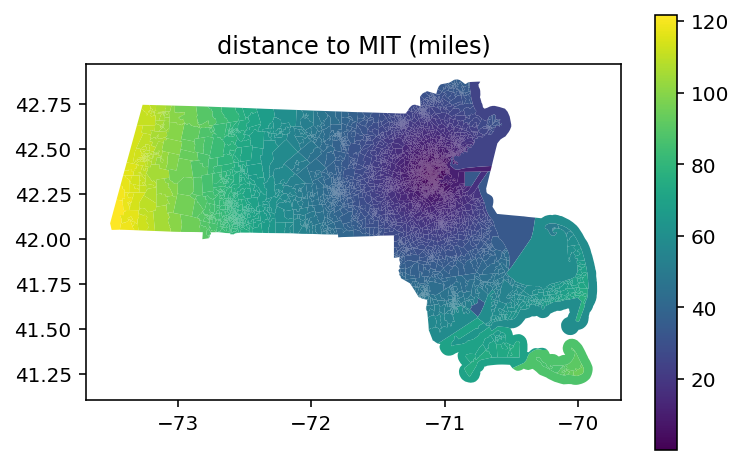

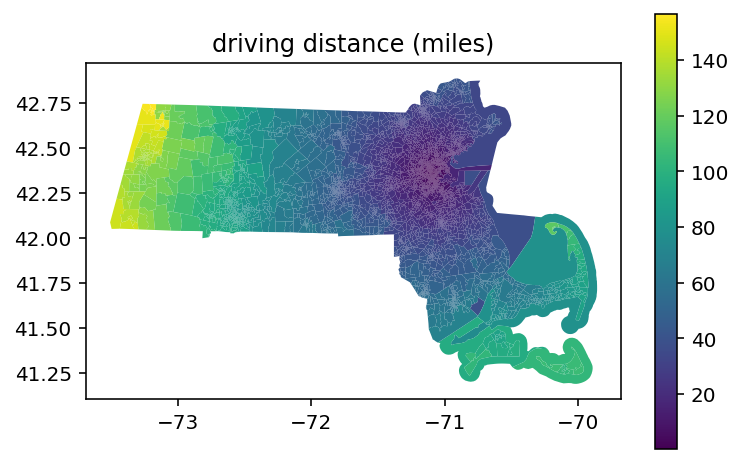

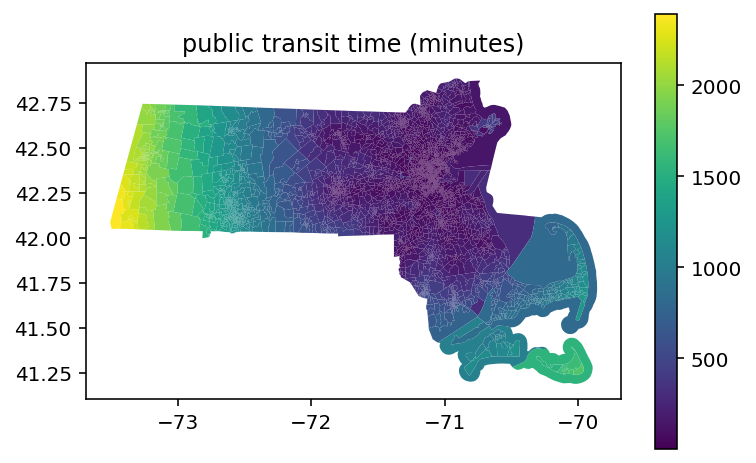

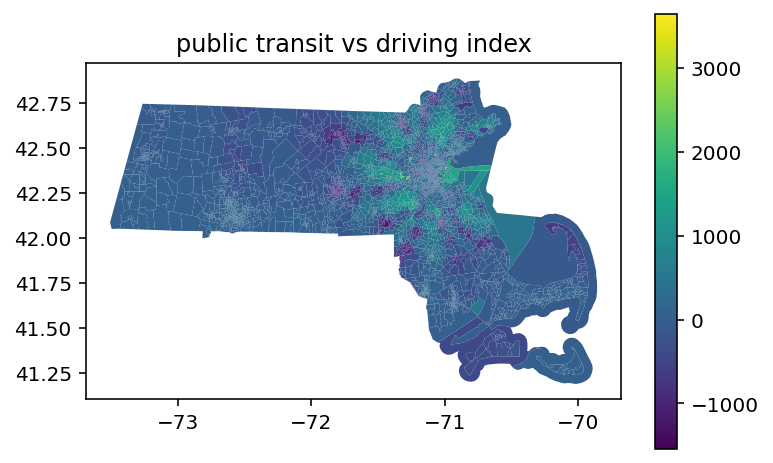

In [879]:
distance_metrics = [
    DISTANCE_TO_MIT,
    DRIVING_DISTANCE, 
    PUBLIC_TRANSIT_TIME,
    PT_VS_DRIVE_INDEX,
]
for dist_m in distance_metrics:
    bg.plot(column=dist_m, legend=True)
    plt.title(dist_m)
    plt.show()

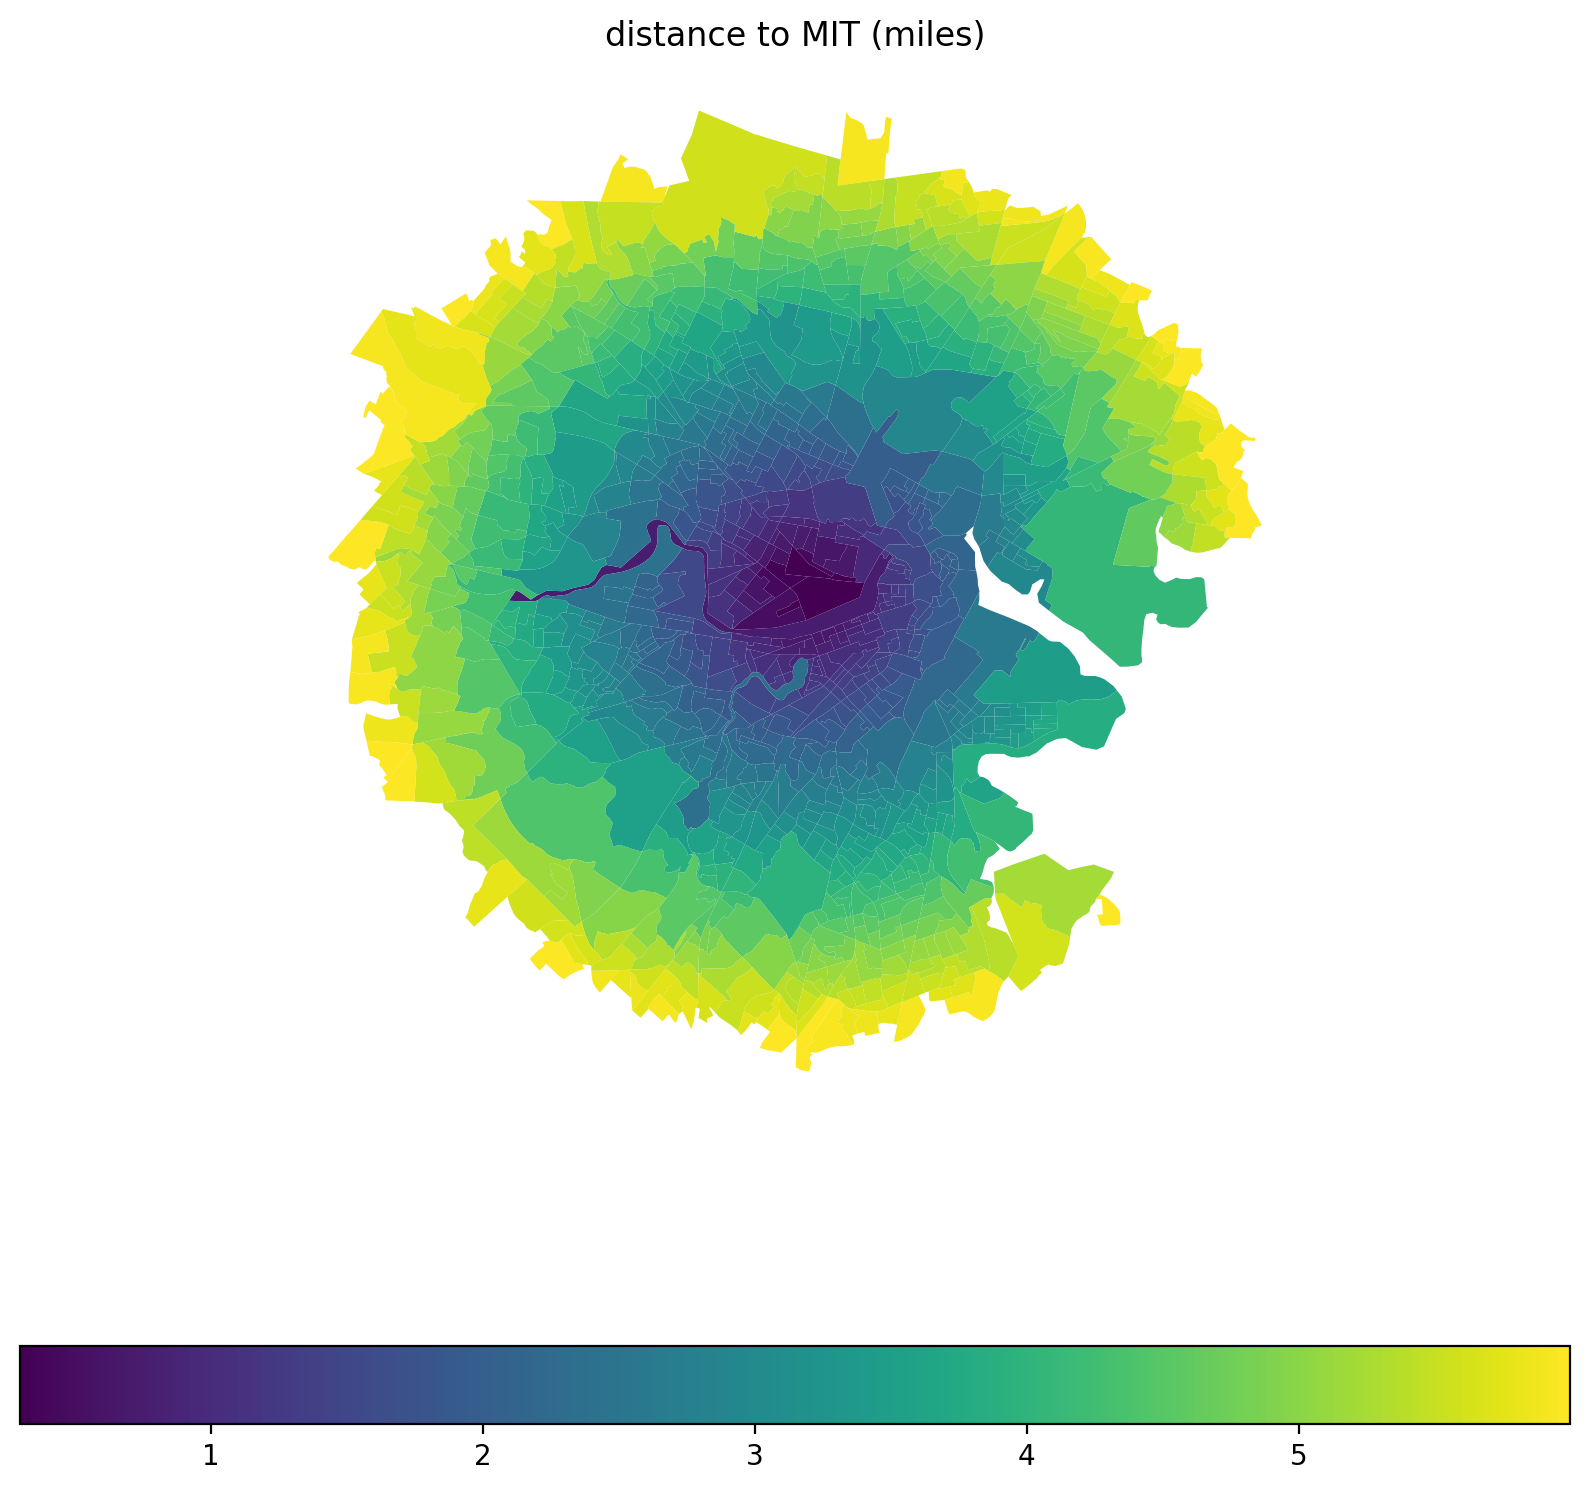

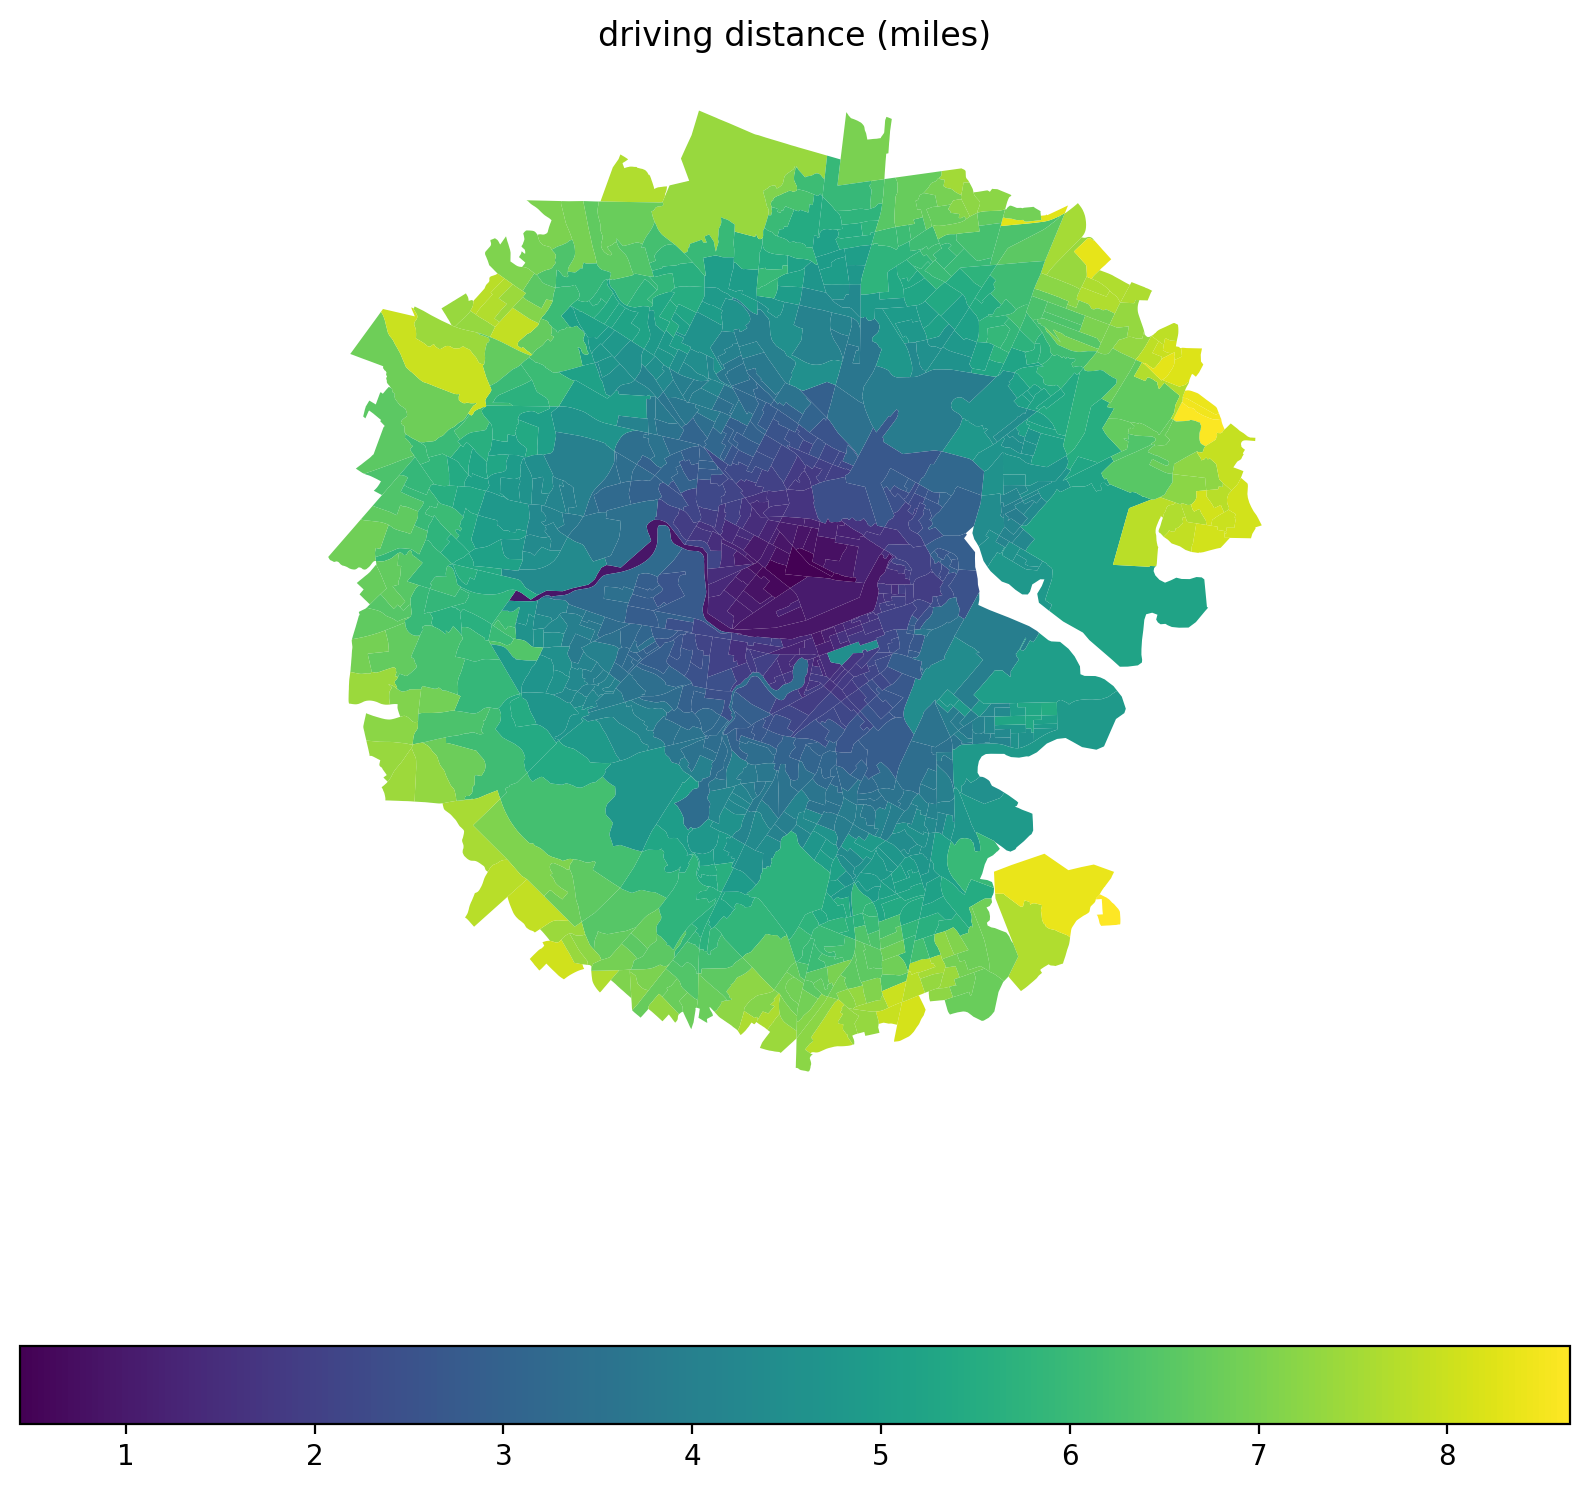

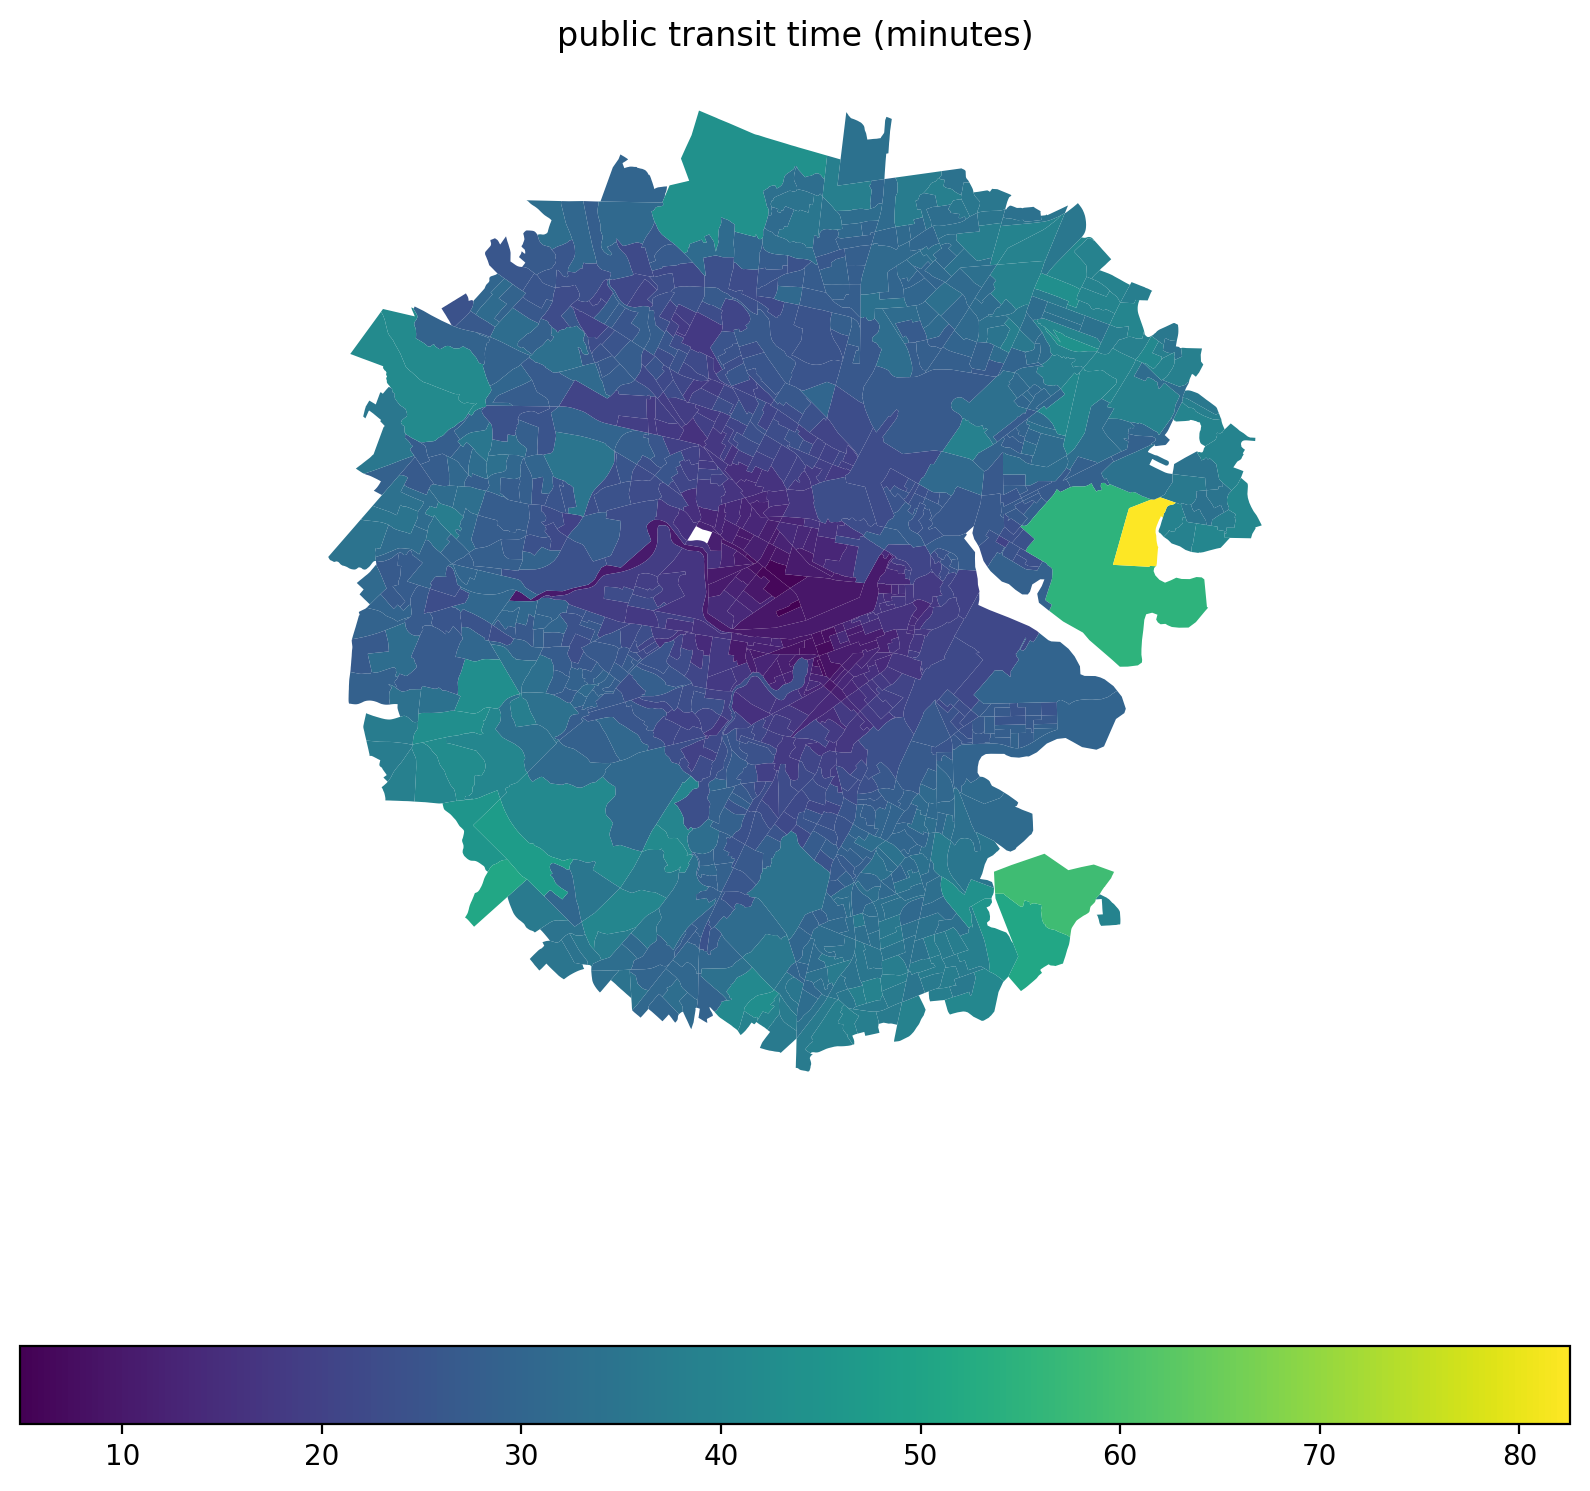

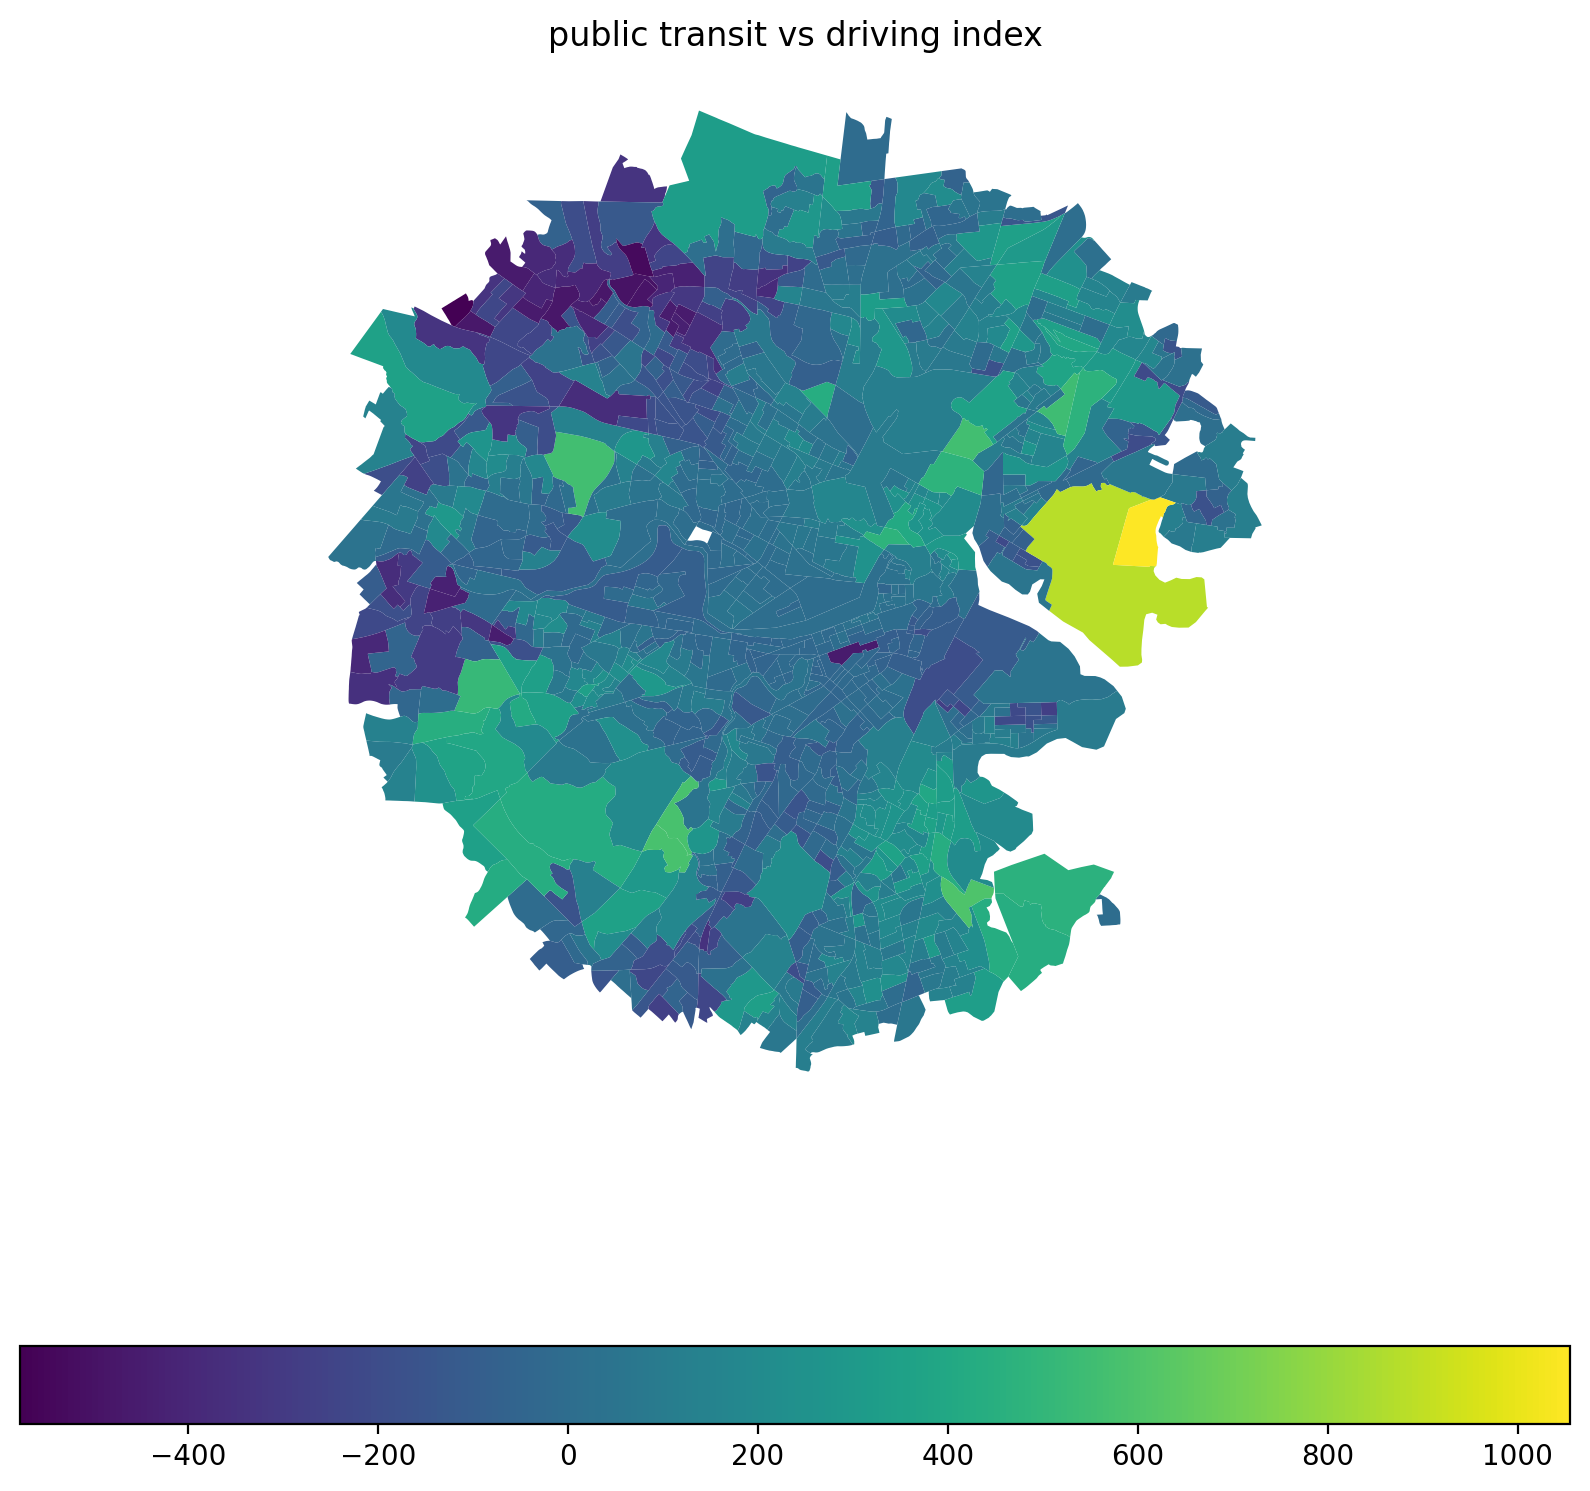

In [880]:
# A close up

for dist_m in [DISTANCE_TO_MIT, DRIVING_DISTANCE]:
    fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
    bg[bg[DISTANCE_TO_MIT]<=6].plot(column=dist_m,
            ax=ax,
            legend=True, 
            legend_kwds={
                'orientation':'horizontal',
            })
    plt.title(dist_m)
    plt.axis('off')
    plt.show()

    

for dist_m in [PUBLIC_TRANSIT_TIME, PT_VS_DRIVE_INDEX]:
    fig, ax = plt.subplots(figsize=(10,10), dpi=100)
    bg[
        (bg[PUBLIC_TRANSIT_TIME]<=90) & (bg[DISTANCE_TO_MIT]<=6)
    ].plot(column=dist_m,
            ax=ax,
            legend=True, 
            legend_kwds={
                'orientation':'horizontal',
            })
    plt.title(dist_m)
    plt.axis('off')
    plt.show()  

In [881]:
def load_data(survey_filepath, bg):
    df = pd.read_csv(survey_filepath,
                         dtype={GEOID: 'str'}, # for easier merging  with shapefile
                          na_values=' ')
    return df.merge(bg, on=GEOID) # People outside of MA are dropped.

In [882]:
survey16_df = load_data(SURVEY16_FILEPATH, bg)
assert(survey16_df['Year'].unique() == [2016])
survey18_df = load_data(SURVEY18_FILEPATH, bg)
assert(survey18_df['Year'].unique() == [2018])

/Users/aberke/projects/CS_MITOS/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (10,60,61,62,63,64,65,66,67,71,72,73,77,82,83,84,86,87,88,91,92,93,98) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/aberke/projects/CS_MITOS/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (10,41,72,73,74,75,76,79,80,81,86,92,93,94,95,96,98,99,100,101,106) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Plot how many people live in each area (2018).

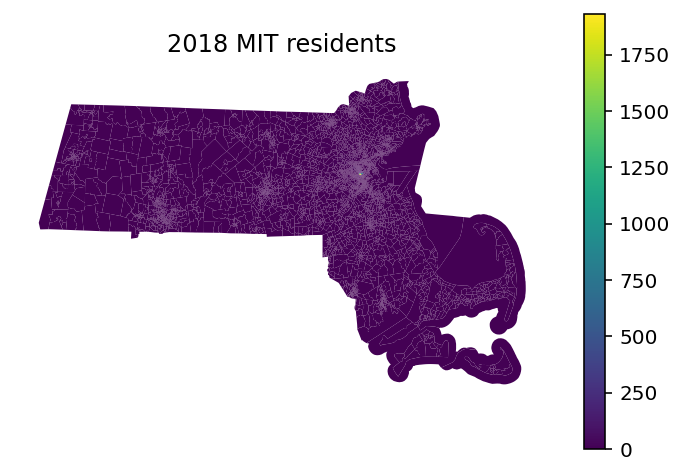

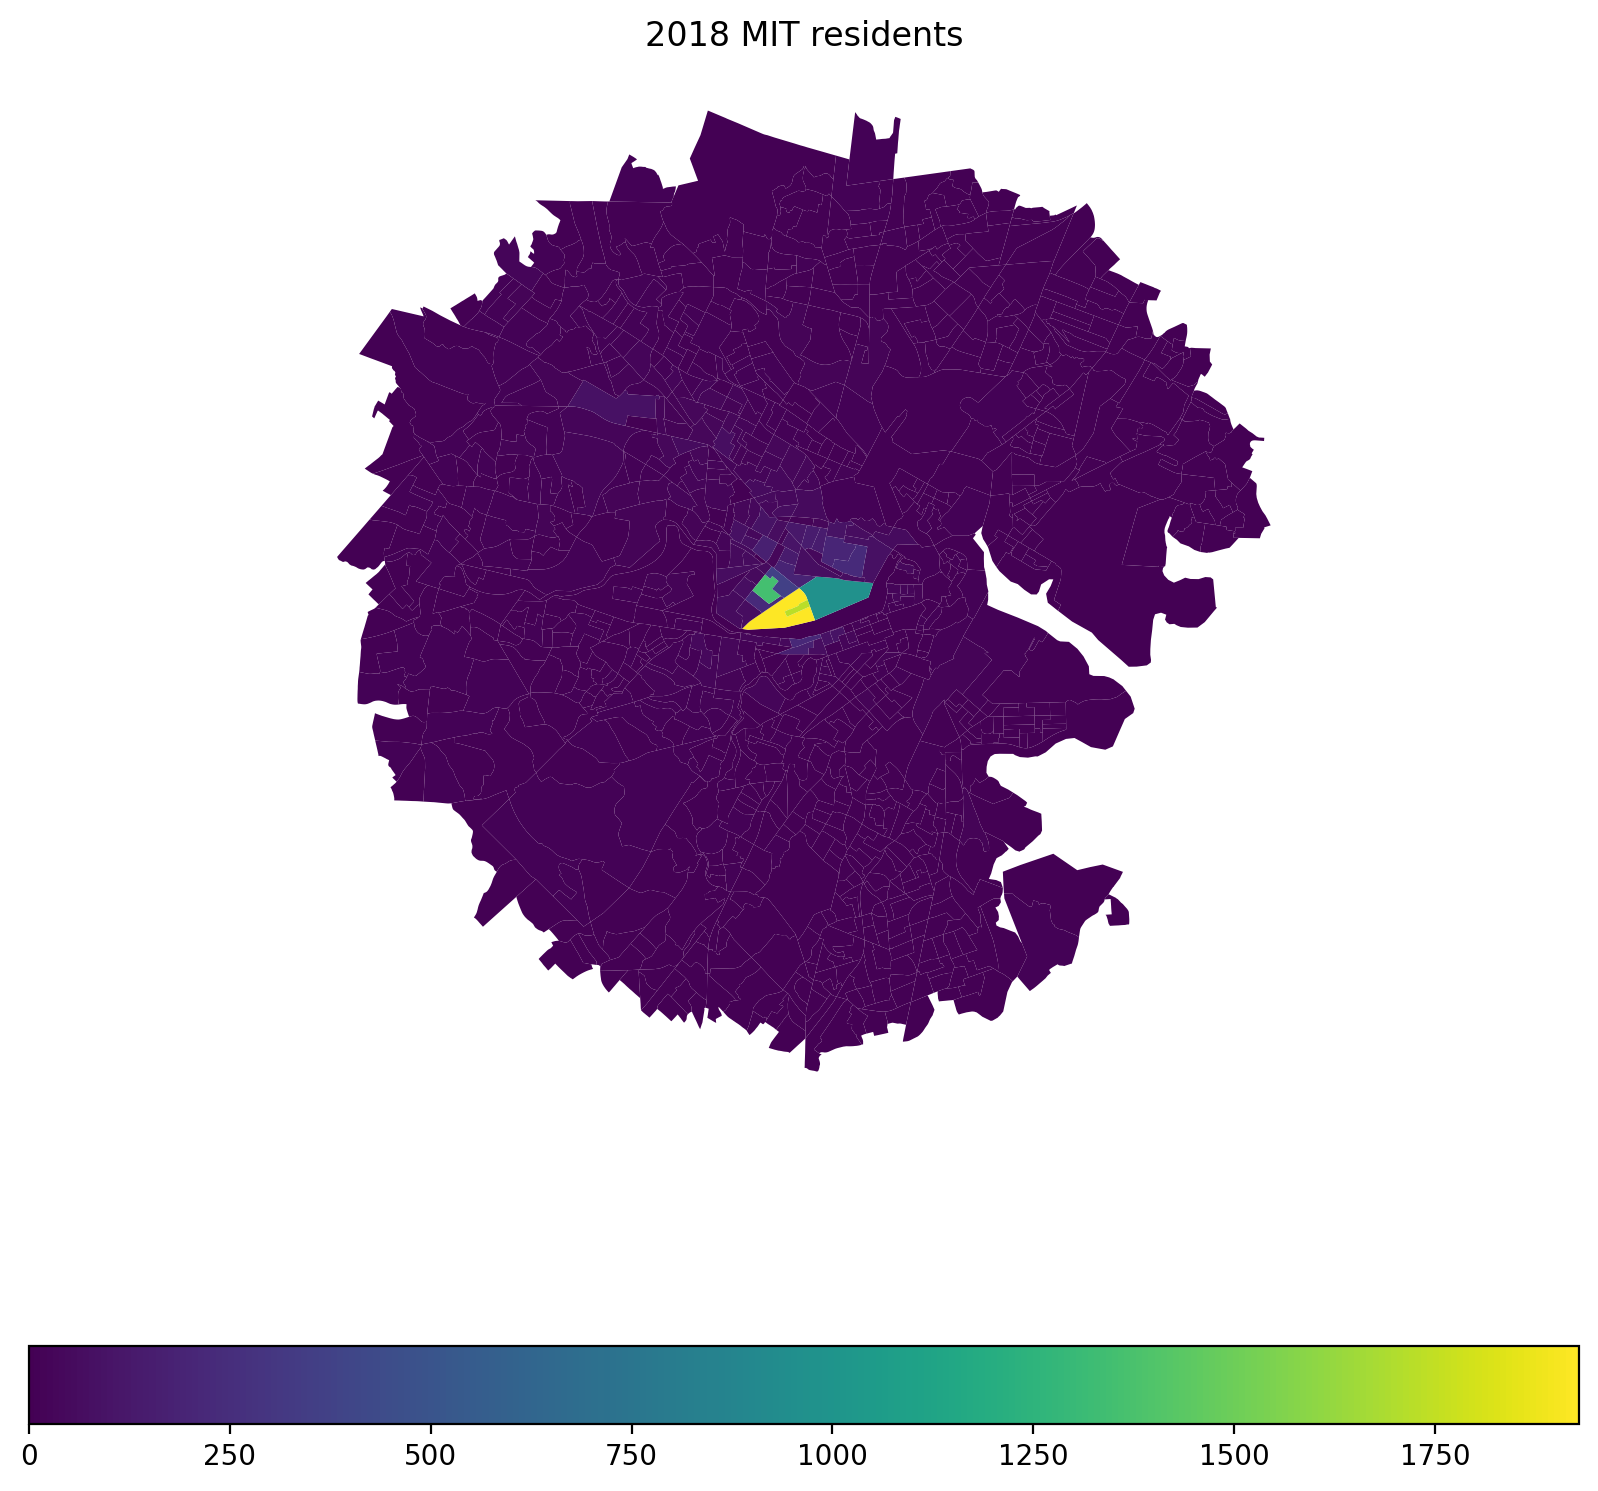

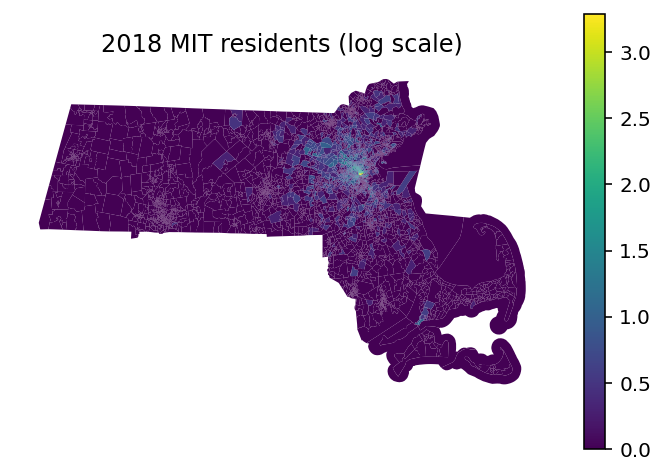

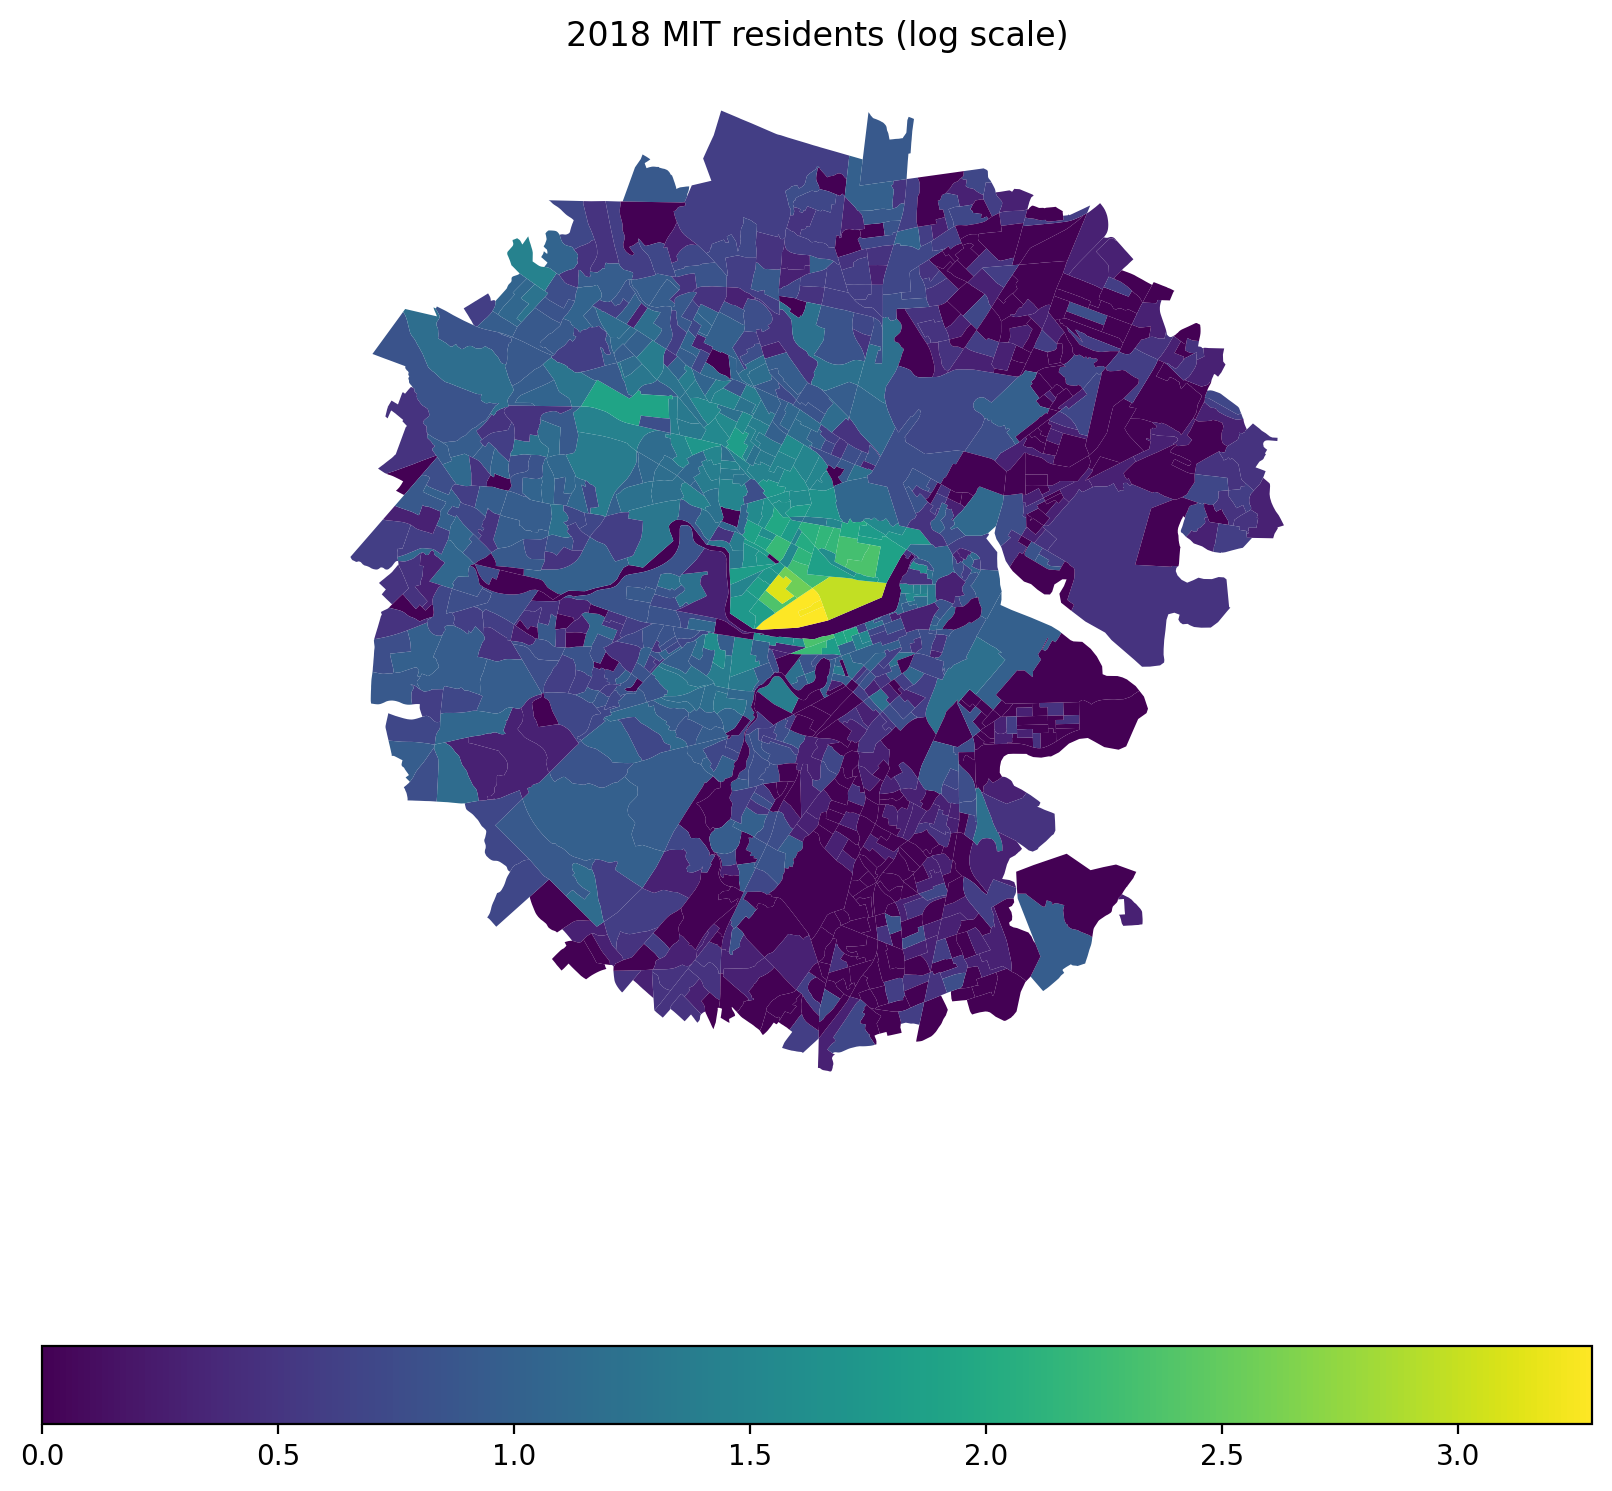

distance to MIT (miles)  driving distance (miles)  \
GEOID                                                             
250173531021                 0.499173                  0.923854   
250173531023                 0.304077                  1.183525   
250173532001                 0.602097                  0.825491   
250173531022                 0.299545                  1.028866   
250173531011                 0.417384                  0.603724   

              public transit time (minutes)  \
GEOID                                         
250173531021                       9.579971   
250173531023                       4.878518   
250173532001                       9.831157   
250173531022                       9.708740   
250173531011                       6.127410   

                                                       geometry  \
GEOID                                                             
250173531021  POLYGON ((-71.10971 42.35307, -71.10923 42.353...   
250173531023  POLYGON ((-71.09915 42.35594, -71.09802 42.356...   
250173532001  POLYGON ((-71.10721 42.36048, -71.10709 42.360...   
250173531022  POLYGON ((-71.09541 42.36050, -71.09456 42.360...   
250173531011  POLYGON ((-71.10399 42.36342, -71.10373 42.363...   

              public transit vs driving index  MIT residents (2018)    logval  \
GEOID                                                                           
250173531021                                4                1929.0  3.285332   
250173531023                              -31                1726.0  3.237041   
250173532001                               11                1353.0  3.131298   
250173531022                               -1                 970.0  2.986772   
250173531011                               -1                 366.0  2.563481   

              2018 MIT residents  2018 MIT residents (log scale)  
GEOID                                                             
250173531021              1929.0                        3.285332  
250173531023              1726.0                        3.237041  
250173532001              1353.0                        3.131298  
250173531022               970.0                        2.986772  
250173531011               366.0                        2.563481

In [883]:
import matplotlib
from numpy import log10

RESIDENTS_18 = '2018 MIT residents'
LOG_RESIDENTS_18 = '2018 MIT residents (log scale)'

bg[RESIDENTS_18] = bg.index.map(survey18_df.groupby(GEOID)[PID].count()).fillna(0)
bg[LOG_RESIDENTS_18] = log10(bg.index.map(survey18_df.groupby(GEOID)[PID].count())).fillna(0)

for c in [RESIDENTS_18, LOG_RESIDENTS_18]:
    bg.plot(
        column=c, 
        legend=True)
    plt.title(c)
    plt.axis('off')
    plt.show()
    fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
    bg[bg[DISTANCE_TO_MIT]<=6].plot(
        column=c,
        ax=ax,
        legend=True, 
        legend_kwds={
            'orientation':'horizontal',
        })
    plt.title(c)
    plt.axis('off')
    plt.show()

bg.sort_values(RESIDENTS_18, ascending=False).head()

How many respondents are present across survey years?

In [884]:
pids16 = set(survey16_df[PID].unique())
pids18 = set(survey18_df[PID].unique())
same_pids = len(pids16.intersection(pids18))
print('%s people in 2016 survey data' % len(pids16))
print('%s people in 2018 survey data' % len(pids18))
print('%s people in both the 2016 and 2018 survey data' % same_pids)

19881 people in 2016 survey data
20077 people in 2018 survey data
11752 people in both the 2016 and 2018 survey data


Q95_16: What are your CURRENT commuting method(s) to MIT? (primary)

Set a boolean flag for when the answer was 'drives alone the entire way'

In [885]:
DRIVES_ALONE = 'drives alone'

survey16_df[DRIVES_ALONE] = (
    (survey16_df['Q95_16']=='Drive alone the entire way')
)
survey18_df[DRIVES_ALONE] = (
    (survey18_df['Q95_16']=='Drive alone the entire way')
)

Compute portion of days people drive alone per week.

In [886]:
# Both the 2016 and 2018 surveys ask respondents how they commuted to campus each day 
# last week.
# However, the responses are coded differently.
# For each survey year, get the number of times they said they 'drive alone' 
# as a portion of the days per week that they did not answer 'NA' or that they were
# not working.
# Set portion to 'NA' if they didn't answer for any days per week.

DRIVE_ALONE_WEIGHTED = 'drives alone (weighted by days per week)'
MOSTLY_DRIVES_ALONE = 'mostly drives alone' # True if drives alone (weighted) >= 0.5

NO_COMMUTE = [
    'Out of office (e.g., sick, vacation, jury duty, business trip)',
    'Scheduled day off (e.g., weekend)',
    'Worked at home',
    'Worked at home or other remote location',
    np.nan,
]

days16 = ['MON','TUE','WED','THU','FRI','SAT','SUN']
days18 = ['week_1','week_2','week_3','week_4','week_5','week_6','week_7']

print(survey16_df['MON'].nunique())
print(survey16_df['MON'].unique())
print(survey18_df['week_1'].nunique())
print(survey18_df['week_1'].unique())

def get_drives_alone_weighted(row, days):
    resp_days = [row[d] for d in days if row[d] not in NO_COMMUTE]
    if len(resp_days):
        return sum((resp == 'Drove alone the entire way') for resp in resp_days)/len(resp_days)
    elif pd.isnull(row['Q95_16']):
        return np.nan
    return 1 if row['Q95_16']=='Drive alone the entire way' else 0

16
[nan 'Walked, then took public transportation' 'Bicycled' 'Worked at home'
 'Drove alone the entire way'
 'Drove alone, then took public transportation' 'Walked'
 'Rode in a private car with another person'
 'Shared ride/dropped off, then took public transportation' 'Other'
 'Out of office (e.g., sick, vacation, jury duty, business trip)'
 'Dropped off at work' 'Bicycled and took public transportation'
 'Scheduled day off (e.g., weekend)'
 'Rode in a private car with 2-4 commuters'
 'Rode in a vanpool (5+ commuters) or private shuttle (e.g. TechShuttle, SafeRide)'
 'Take a taxi or ride service (e.g., Uber, Lyft)']
15
['Drove alone the entire way' 'Worked at home or other remote location'
 nan 'Rode in a private car with 1-4 commuters'
 'Walked, then took public transportation'
 'Out of office (e.g., sick, vacation, jury duty, business trip)'
 'Drove alone, then took public transportation' 'Walked'
 'Dropped off at work' 'Bicycled'
 'Shared ride/dropped off, then took public transpor

In [887]:
survey16_df[DRIVE_ALONE_WEIGHTED] = survey16_df.apply(get_drives_alone_weighted,
                                                      axis=1, args=([days16]))
survey16_df[MOSTLY_DRIVES_ALONE] = (survey16_df[DRIVE_ALONE_WEIGHTED] >= 0.5)
survey16_df[
    ['TYPE_NUM', DRIVES_ALONE]+week_days16+[DRIVE_ALONE_WEIGHTED, MOSTLY_DRIVES_ALONE]
].head()

TYPE_NUM  drives alone  \
0             Support Staff         False   
1      Administrative Staff         False   
2  Sponsored Research Staff         False   
3             Support Staff         False   
4                   Faculty         False   

                                       MON  \
0                                      NaN   
1                                      NaN   
2  Walked, then took public transportation   
3  Walked, then took public transportation   
4                                      NaN   

                                       TUE  \
0                                      NaN   
1                                      NaN   
2  Walked, then took public transportation   
3  Walked, then took public transportation   
4                                      NaN   

                                       WED  \
0                                      NaN   
1                                      NaN   
2  Walked, then took public transportation   
3  Walked, then took public transportation   
4                                      NaN   

                                       THU  \
0                                      NaN   
1                                      NaN   
2  Walked, then took public transportation   
3  Walked, then took public transportation   
4                                      NaN   

                                       FRI                                SAT  \
0                                      NaN                                NaN   
1                                      NaN                                NaN   
2  Walked, then took public transportation                                NaN   
3  Walked, then took public transportation  Scheduled day off (e.g., weekend)   
4                                      NaN                                NaN   

                                 SUN  \
0                                NaN   
1                                NaN   
2                                NaN   
3  Scheduled day off (e.g., weekend)   
4                                NaN   

   drives alone (weighted by days per week)  mostly drives alone  
0                                       NaN                False  
1                                       NaN                False  
2                                       0.0                False  
3                                       0.0                False  
4                                       NaN                False

In [888]:
survey18_df[DRIVE_ALONE_WEIGHTED] = survey18_df.apply(get_drives_alone_weighted,
                                                      axis=1, args=([days18]))
survey18_df[MOSTLY_DRIVES_ALONE] = (survey18_df[DRIVE_ALONE_WEIGHTED] >= 0.5)
survey18_df[
    ['TYPE_NUM', DRIVES_ALONE]+week_days18+[DRIVE_ALONE_WEIGHTED, MOSTLY_DRIVES_ALONE]
].head()

TYPE_NUM  drives alone  \
0             Support Staff          True   
1      Administrative Staff         False   
2                   Faculty         False   
3  Sponsored Research Staff         False   
4                   Faculty         False   

                                    week_1  \
0               Drove alone the entire way   
1  Worked at home or other remote location   
2                                      NaN   
3  Worked at home or other remote location   
4                                      NaN   

                                    week_2  \
0               Drove alone the entire way   
1  Walked, then took public transportation   
2                                      NaN   
3  Walked, then took public transportation   
4                                      NaN   

                                    week_3  \
0               Drove alone the entire way   
1  Walked, then took public transportation   
2                                      NaN   
3  Walked, then took public transportation   
4                                      NaN   

                                    week_4  \
0               Drove alone the entire way   
1  Worked at home or other remote location   
2                                      NaN   
3  Walked, then took public transportation   
4                                      NaN   

                                    week_5  \
0                                      NaN   
1  Worked at home or other remote location   
2                                      NaN   
3  Walked, then took public transportation   
4                                      NaN   

                                              week_6  \
0                                                NaN   
1  Out of office (e.g., sick, vacation, jury duty...   
2                                                NaN   
3                  Scheduled day off (e.g., weekend)   
4                                                NaN   

                                              week_7  \
0                                                NaN   
1  Out of office (e.g., sick, vacation, jury duty...   
2                                                NaN   
3                  Scheduled day off (e.g., weekend)   
4                                                NaN   

   drives alone (weighted by days per week)  mostly drives alone  
0                                       1.0                 True  
1                                       0.0                False  
2                                       NaN                False  
3                                       0.0                False  
4                                       NaN                False

In [889]:
print('2016\n------')
a = len(survey16_df[
    survey16_df['Q95_16'].notnull()
])
print('%s / %s  = %.02f answered about primary commute method'%(a, len(survey16_df),
                                                                a/len(survey16_df)))
a = len(survey16_df[
    survey16_df[DRIVE_ALONE_WEIGHTED].notnull()
])
print('%s / %s  = %.02f answered about commute at all'%(a, len(survey16_df),
                                                                a/len(survey16_df)))
print('')
print('2018\n------')
a = len(survey18_df[
    survey18_df['Q95_16'].notnull()
])
print('%s / %s  = %.02f answered about primary commute method'%(a, len(survey18_df),
                                                                a/len(survey18_df)))
a = len(survey18_df[
    survey18_df[DRIVE_ALONE_WEIGHTED].notnull()
])
print('%s / %s  = %.02f answered about commute at all'%(a, len(survey18_df),
                                                                a/len(survey18_df)))

2016
------
9700 / 19881  = 0.49 answered about primary commute method
9752 / 19881  = 0.49 answered about commute at all

2018
------
9702 / 20077  = 0.48 answered about primary commute method
9760 / 20077  = 0.49 answered about commute at all


Limit the data to respondents who answered about commute method and merge survey years.



In [909]:
s_16_18_df = survey16_df[survey16_df[DRIVE_ALONE_WEIGHTED].notnull()].set_index(PID)[
    [GEOID, 'TYPE_NUM', DRIVES_ALONE, DRIVE_ALONE_WEIGHTED, MOSTLY_DRIVES_ALONE] + distance_metrics + [GEOMETRY]
].merge(survey18_df[survey18_df[DRIVE_ALONE_WEIGHTED].notnull()].set_index(PID)[
    [GEOID, 'TYPE_NUM', DRIVES_ALONE, DRIVE_ALONE_WEIGHTED, MOSTLY_DRIVES_ALONE] + distance_metrics + [GEOMETRY]
], on=PID, how='inner', suffixes=[' 2016', ' 2018'])#.dropna()
print('columns')
print(list(s_16_18_df.columns))
s_16_18_df.reset_index().drop(PID, axis=1).head(2)

columns
['GEOID 2016', 'TYPE_NUM 2016', 'drives alone 2016', 'drives alone (weighted by days per week) 2016', 'mostly drives alone 2016', 'distance to MIT (miles) 2016', 'driving distance (miles) 2016', 'public transit time (minutes) 2016', 'public transit vs driving index 2016', 'geometry 2016', 'GEOID 2018', 'TYPE_NUM 2018', 'drives alone 2018', 'drives alone (weighted by days per week) 2018', 'mostly drives alone 2018', 'distance to MIT (miles) 2018', 'driving distance (miles) 2018', 'public transit time (minutes) 2018', 'public transit vs driving index 2018', 'geometry 2018']


GEOID 2016             TYPE_NUM 2016  drives alone 2016  \
0  250173549001  Sponsored Research Staff              False   
1  250173549001             Support Staff              False   

   drives alone (weighted by days per week) 2016  mostly drives alone 2016  \
0                                            0.0                     False   
1                                            0.0                     False   

   distance to MIT (miles) 2016  driving distance (miles) 2016  \
0                       3.11135                       3.745935   
1                       3.11135                       3.745935   

   public transit time (minutes) 2016  public transit vs driving index 2016  \
0                           17.930805                                  -195   
1                           17.930805                                  -195   

                                       geometry 2016    GEOID 2018  \
0  POLYGON ((-71.13326 42.39733, -71.13221 42.397...  250214177011   
1  POLYGON ((-71.13326 42.39733, -71.13221 42.397...  250173549001   

          TYPE_NUM 2018  drives alone 2018  \
0  Administrative Staff              False   
1         Support Staff              False   

   drives alone (weighted by days per week) 2018  mostly drives alone 2018  \
0                                            0.0                     False   
1                                            0.0                     False   

   distance to MIT (miles) 2018  driving distance (miles) 2018  \
0                       8.31461                       9.325474   
1                       3.11135                       3.745935   

   public transit time (minutes) 2018  public transit vs driving index 2018  \
0                           39.176264                                   -91   
1                           17.930805                                  -195   

                                       geometry 2018  
0  POLYGON ((-71.01086 42.25748, -71.01032 42.257...  
1  POLYGON ((-71.13326 42.39733, -71.13221 42.397...

In [910]:
print('%s people with both 2016 and 2018 completed survey data'%len(s_16_18_df))

4090 people with both 2016 and 2018 completed survey data


In [911]:
s_16_18_df[
    s_16_18_df[DRIVE_ALONE_WEIGHTED + ' 2018']>0
][[DRIVE_ALONE_WEIGHTED + ' 2016', DRIVE_ALONE_WEIGHTED + ' 2018']].head()

drives alone (weighted by days per week) 2016  \
PID                                                               
TR2016_2018_5602                                            0.0   
TR2016_2018_7447                                            1.0   
TR2016_2018_19                                              1.0   
TR2016_2018_9010                                            0.0   
TR2016_2018_31                                              1.0   

                  drives alone (weighted by days per week) 2018  
PID                                                              
TR2016_2018_5602                                            0.2  
TR2016_2018_7447                                            1.0  
TR2016_2018_19                                              1.0  
TR2016_2018_9010                                            0.8  
TR2016_2018_31                                              1.0

<AxesSubplot:>

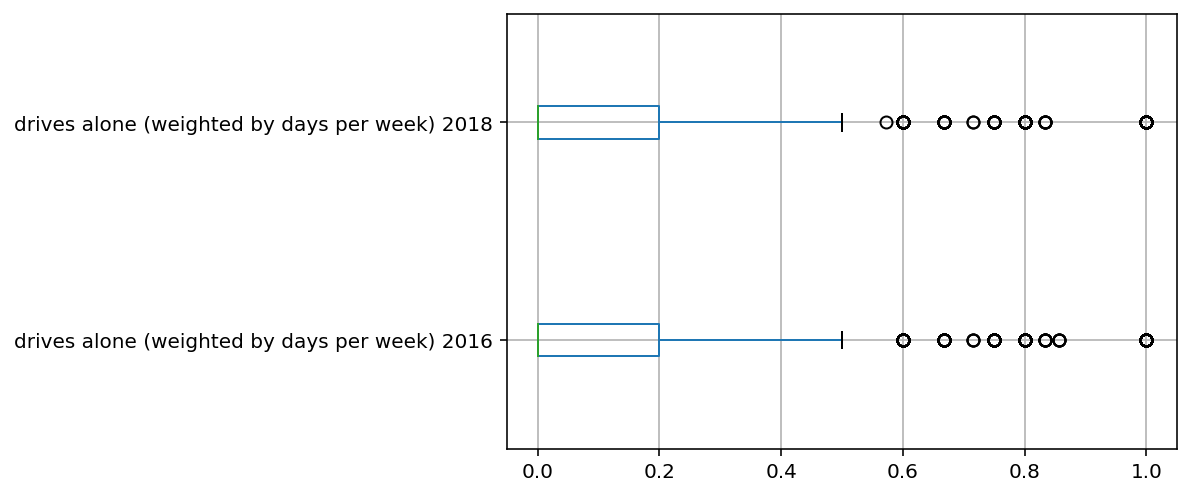

In [912]:
s_16_18_df.boxplot(
    column=[DRIVE_ALONE_WEIGHTED + ' 2016', DRIVE_ALONE_WEIGHTED + ' 2018'],
    vert=False,
)

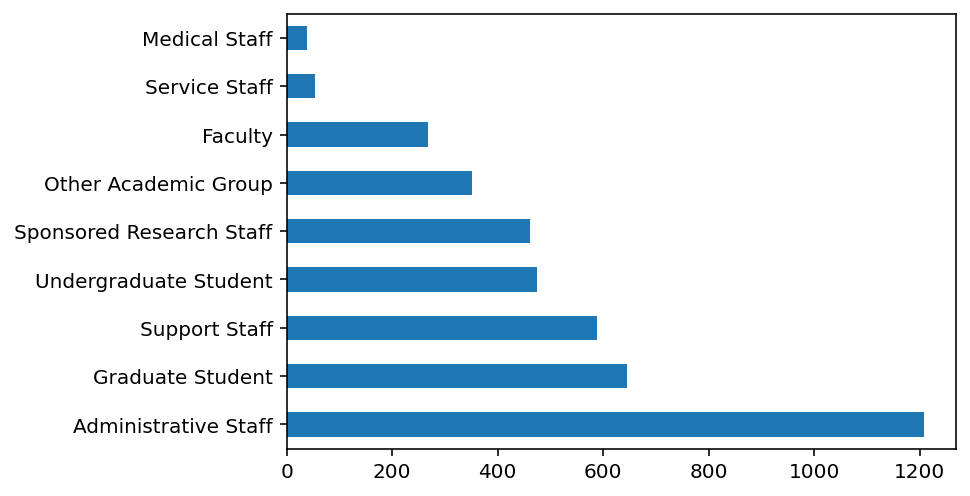

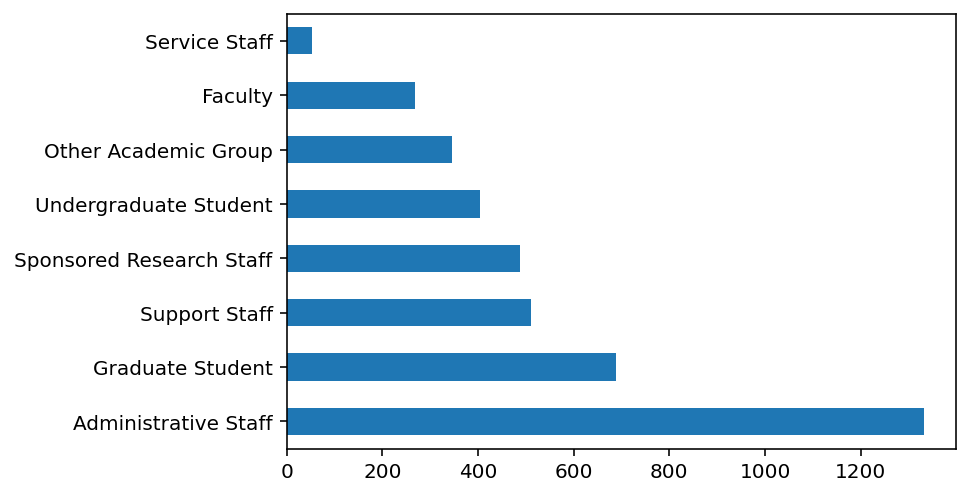

In [913]:
s_16_18_df['TYPE_NUM 2016'].value_counts().plot.barh()
plt.show()
s_16_18_df['TYPE_NUM 2018'].value_counts().plot.barh()
plt.show()

Where did the medical staff go?

Answer: They were consumed by the Administrative Staff group.

In [914]:
print(s_16_18_df[s_16_18_df['TYPE_NUM 2016'] == 'Medical Staff']['TYPE_NUM 2018'].unique())

['Administrative Staff']


Show the distribution of distances from MIT.


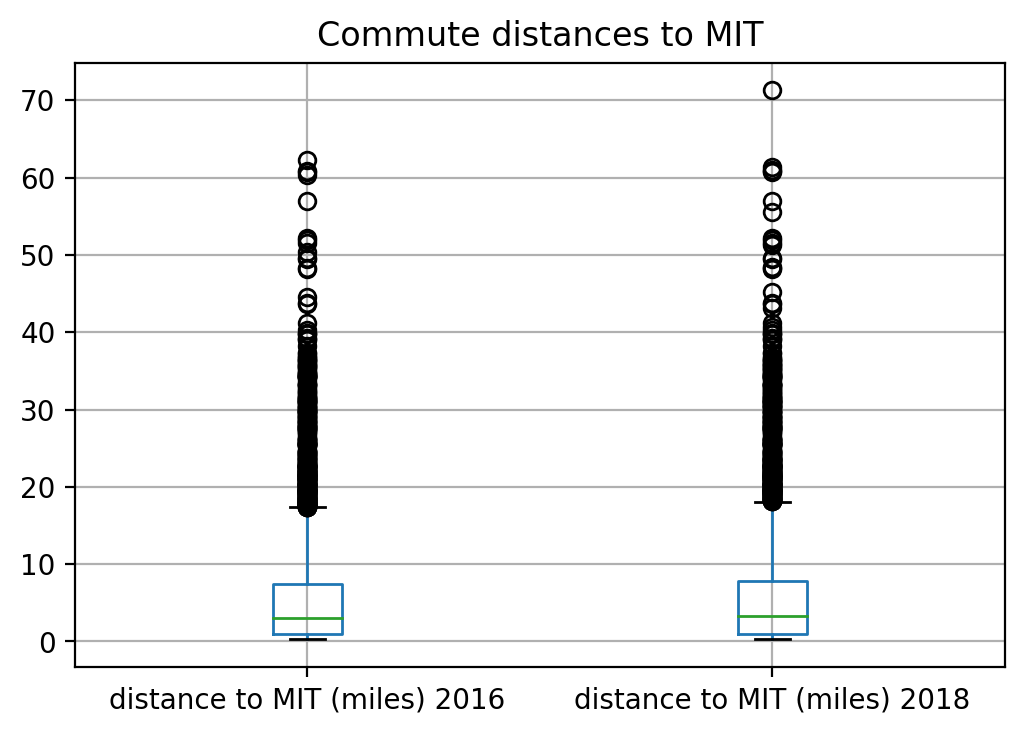

In [915]:
fig, ax = plt.subplots(1, dpi=100)
boxplot = s_16_18_df.boxplot(ax=ax,column=[DISTANCE_TO_MIT+' 2016',DISTANCE_TO_MIT+' 2018'])
plt.title('Commute distances to MIT')
plt.show()

In [916]:
car_commuter_16_distances = s_16_18_df[
    s_16_18_df[MOSTLY_DRIVES_ALONE + ' 2016']==True
][DISTANCE_TO_MIT + ' 2016']
non_car_commuter_16_distances = s_16_18_df[
    s_16_18_df[MOSTLY_DRIVES_ALONE + ' 2016']==False
][DISTANCE_TO_MIT + ' 2016']

car_commuter_18_distances = s_16_18_df[
    s_16_18_df[MOSTLY_DRIVES_ALONE + ' 2018']==True
][DISTANCE_TO_MIT + ' 2018']
non_car_commuter_18_distances = s_16_18_df[
    s_16_18_df[MOSTLY_DRIVES_ALONE + ' 2018']==False
][DISTANCE_TO_MIT + ' 2018']

In [917]:
car_commuter_16_distances.describe()

count    832.000000
mean      10.572190
std        8.446813
min        0.299545
25%        4.704860
50%        7.790790
75%       13.904512
max       51.990288
Name: distance to MIT (miles) 2016, dtype: float64

In [918]:
non_car_commuter_16_distances.describe()

count    3258.000000
mean        4.857421
std         7.241038
min         0.299545
25%         0.678539
50%         2.142490
75%         5.469538
max        62.297936
Name: distance to MIT (miles) 2016, dtype: float64

In [919]:
car_commuter_18_distances.describe()

count    877.000000
mean      10.728551
std        8.686614
min        0.304077
25%        4.918860
50%        7.715539
75%       14.352413
max       71.336863
Name: distance to MIT (miles) 2018, dtype: float64

In [920]:
non_car_commuter_18_distances.describe()

count    3213.000000
mean        5.120361
std         7.532513
min         0.299545
25%         0.807188
50%         2.279205
75%         5.749336
max        61.373899
Name: distance to MIT (miles) 2018, dtype: float64

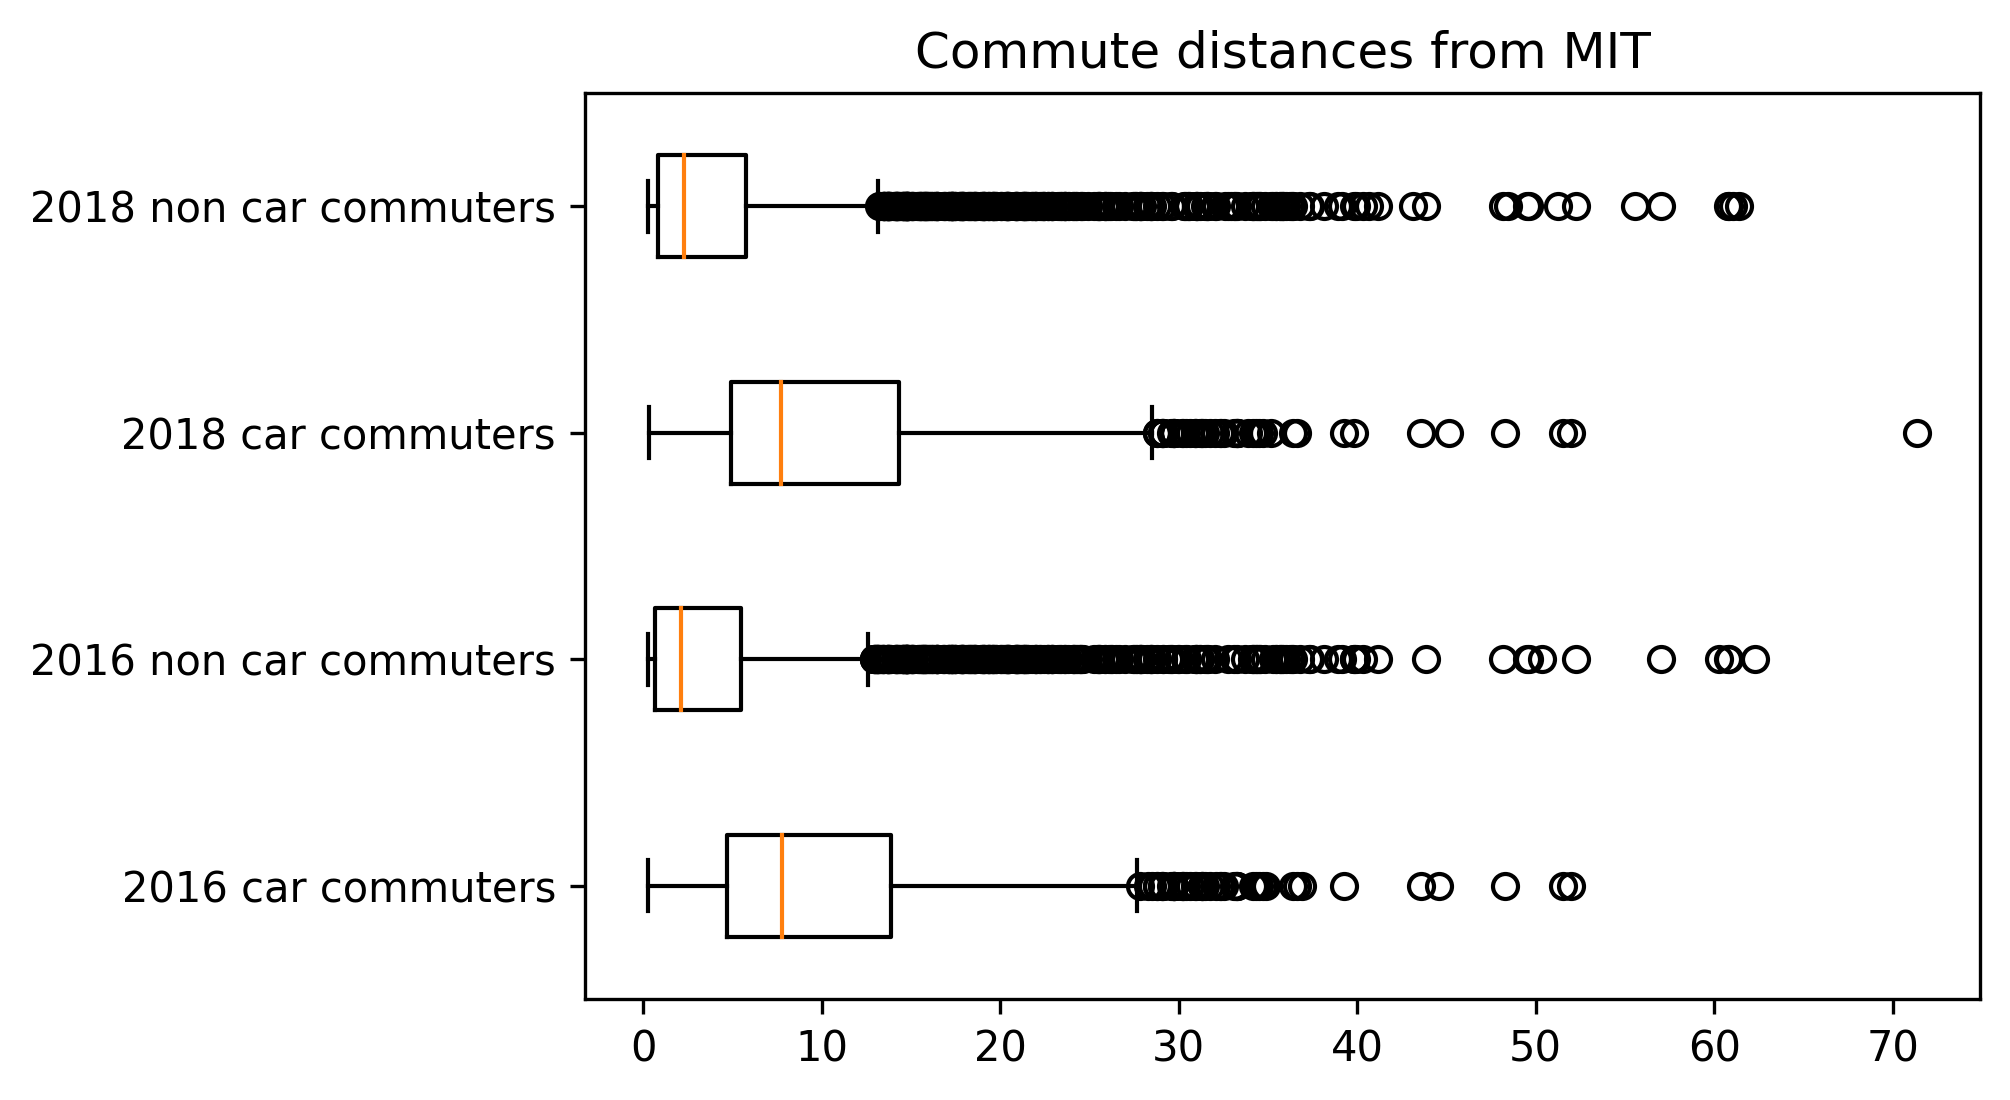

In [921]:
fig, ax = plt.subplots(1, dpi=150)
boxplot = ax.boxplot([
    car_commuter_16_distances,
    non_car_commuter_16_distances,
    car_commuter_18_distances,
    non_car_commuter_18_distances
], labels=[
    '2016 car commuters', 
    '2016 non car commuters', 
    '2018 car commuters',
    '2018 non car commuters'
], vert=False)
plt.title('Commute distances from MIT')
plt.show()

How many people moved block groups?

In [922]:
moved = len(s_16_18_df[
    (s_16_18_df['GEOID 2016'] != s_16_18_df['GEOID 2018'])
])
print('%s survey respondents moved block groups' % moved)

1053 survey respondents moved block groups


Mark people's change in how  often they commute by driving alone.

Then compare change in commuting behavior by relocation status.

Drives alone change: Indicates change from 2016 to 2018 in number of days per  week people commuted  to MIT by driving alone
- 0: No change
- -1: Drives alone less often
- +1: Drives alone more often

In [923]:
DRIVES_ALONE_CHANGE = 'change in driving alone from 2016 to 2018' # 0, -1, +1

def get_drives_alone_change(row):
    if row[DRIVE_ALONE_WEIGHTED + ' 2016']==row[DRIVE_ALONE_WEIGHTED + ' 2018']:
        return 0
    # drives less often
    if row[DRIVE_ALONE_WEIGHTED + ' 2016'] > row[DRIVE_ALONE_WEIGHTED + ' 2018']:
        return -1
    # drives more often
    elif row[DRIVE_ALONE_WEIGHTED + ' 2016'] < row[DRIVE_ALONE_WEIGHTED + ' 2018']:
        return 1

def get_primarily_drives_alone_change(row):
    if row[DRIVES_ALONE + ' 2016']==row[DRIVES_ALONE + ' 2018']:
        return 0
    # primarily drives alone --> not primarily drives alone
    if row[DRIVES_ALONE + ' 2016'] and not row[DRIVES_ALONE + ' 2018']:
        return -1
    # not primarily drives alone --> primarily drives alone
    else:
        return 1

s_16_18_df[DRIVES_ALONE_CHANGE] = s_16_18_df.apply(get_drives_alone_change, axis=1)

Mark whether people moved closer. Where the distance metric is each of our distance metrics
- line distance
- time on public transit
- driving distance
- PT vs driving index


In [924]:
MOVED_CLOSER = 'moved closer to MIT'
MOVED_CLOSER_PT = 'moved closer (w.r.t. public transit commute time)'
MOVED_CLOSER_DRIVING = 'moved closer (w.r.t. driving distance)'
MOVED_CLOSER_PT_VS_DRIVING_INDEX = 'moved closer (w.r.t. public transit vs driving index)'

s_16_18_df[MOVED_CLOSER] = (
    s_16_18_df[DISTANCE_TO_MIT + ' 2016'] > s_16_18_df[DISTANCE_TO_MIT + ' 2018']
)
s_16_18_df[MOVED_CLOSER_PT] = (
    s_16_18_df[PUBLIC_TRANSIT_TIME + ' 2016'] > s_16_18_df[PUBLIC_TRANSIT_TIME + ' 2018']
)
s_16_18_df[MOVED_CLOSER_DRIVING] = (
    s_16_18_df[DRIVING_DISTANCE + ' 2016'] > s_16_18_df[DRIVING_DISTANCE + ' 2018']
)
s_16_18_df[MOVED_CLOSER_PT_VS_DRIVING_INDEX] = (
    s_16_18_df[PT_VS_DRIVE_INDEX + ' 2016'] > s_16_18_df[PT_VS_DRIVE_INDEX + ' 2018']
)

## Show the aggregate changes by relocation status.



N  Primarily drives alone (2016)  \
Relocation status                                                   
Moved closer to MIT            374                             44   
Moved further or didn't move  3716                            767   
Total                         4090                            811   

                              Primarily drives alone (2018)  \
Relocation status                                             
Moved closer to MIT                                      41   
Moved further or didn't move                            792   
Total                                                   833   

                              % Change in commuters mostly driving alone  
Relocation status                                                         
Moved closer to MIT                                                -6.82  
Moved further or didn't move                                        3.26  
Total                                                               2.71

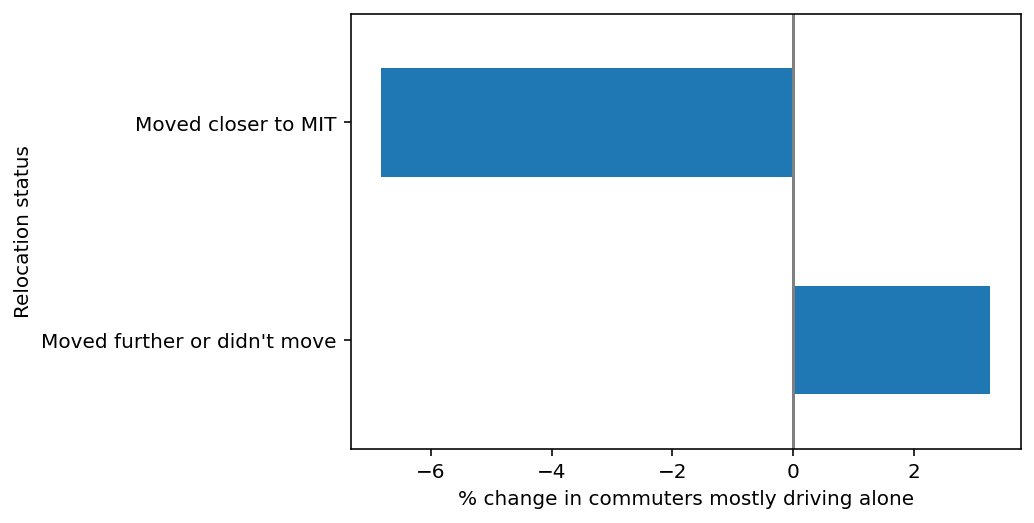

In [926]:
distance_agg_change_df = pd.DataFrame({
        'N': [
            len(s_16_18_df[s_16_18_df[MOVED_CLOSER]==True]),
            len(s_16_18_df[s_16_18_df[MOVED_CLOSER]==False]),
        ],
        'Primarily drives alone (2016)': [
            s_16_18_df[s_16_18_df[MOVED_CLOSER]==True][DRIVES_ALONE+' 2016'].sum(),
            s_16_18_df[s_16_18_df[MOVED_CLOSER]==False][DRIVES_ALONE+' 2016'].sum(),
        ],
        'Primarily drives alone (2018)': [
            s_16_18_df[s_16_18_df[MOVED_CLOSER]==True][DRIVES_ALONE+' 2018'].sum(),
            s_16_18_df[s_16_18_df[MOVED_CLOSER]==False][DRIVES_ALONE+' 2018'].sum(),
        ], 
    },
    index=pd.Index(
        data=['Moved closer to MIT', 'Moved further or didn\'t move'], 
        name='Relocation status'
    ))
distance_agg_change_df.loc['Total'] = distance_agg_change_df.sum()
distance_agg_change_df['% Change in commuters mostly driving alone'] = \
    round(100*((distance_agg_change_df['Primarily drives alone (2018)'] \
                - distance_agg_change_df['Primarily drives alone (2016)'])\
               /distance_agg_change_df['Primarily drives alone (2016)']), 2)

distance_agg_change_df.loc[
    ['Moved closer to MIT', 'Moved further or didn\'t move']
]['% Change in commuters mostly driving alone'].sort_values(ascending=False).plot.barh()
plt.axvline(0, color='gray')
plt.xlabel('% change in commuters mostly driving alone')

distance_agg_change_df

N  Primarily drives alone (2016)  \
Relocation status                                                   
Moved closer to MIT            403                             48   
Moved further or didn't move  3687                            763   
Total                         4090                            811   

                              Primarily drives alone (2018)  \
Relocation status                                             
Moved closer to MIT                                      44   
Moved further or didn't move                            789   
Total                                                   833   

                              % Change in commuters mostly driving alone  
Relocation status                                                         
Moved closer to MIT                                                -8.33  
Moved further or didn't move                                        3.41  
Total                                                               2.71

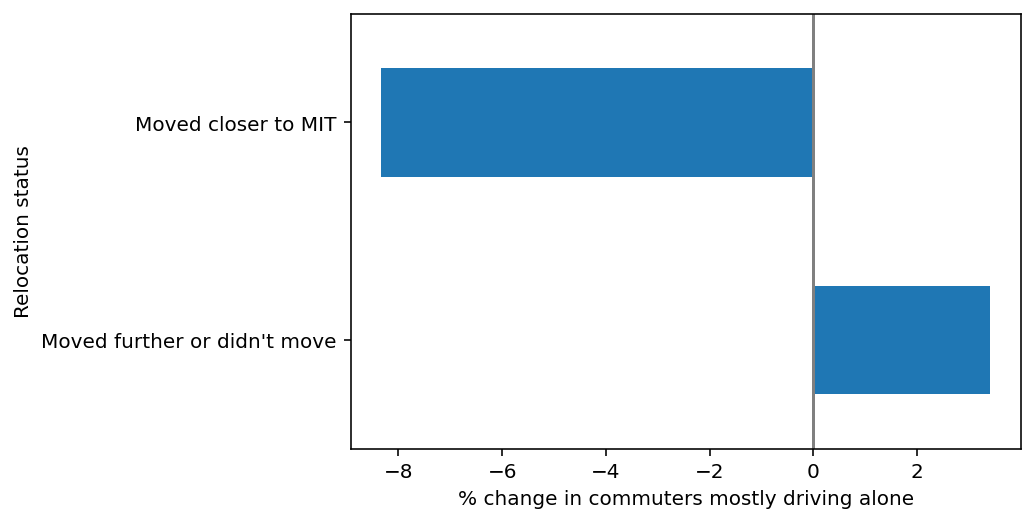

In [927]:
driving_distance_agg_change_df = pd.DataFrame({
        'N': [
            len(s_16_18_df[s_16_18_df[MOVED_CLOSER_DRIVING]==True]),
            len(s_16_18_df[s_16_18_df[MOVED_CLOSER_DRIVING]==False]),
        ],
        'Primarily drives alone (2016)': [
            s_16_18_df[s_16_18_df[MOVED_CLOSER_DRIVING]==True][DRIVES_ALONE+' 2016'].sum(),
            s_16_18_df[s_16_18_df[MOVED_CLOSER_DRIVING]==False][DRIVES_ALONE+' 2016'].sum(),
        ],
        'Primarily drives alone (2018)': [
            s_16_18_df[s_16_18_df[MOVED_CLOSER_DRIVING]==True][DRIVES_ALONE+' 2018'].sum(),
            s_16_18_df[s_16_18_df[MOVED_CLOSER_DRIVING]==False][DRIVES_ALONE+' 2018'].sum(),
        ], 
    },
    index=pd.Index(
        data=['Moved closer to MIT', 'Moved further or didn\'t move'], 
        name='Relocation status'
    ))
driving_distance_agg_change_df.loc['Total'] = driving_distance_agg_change_df.sum()
driving_distance_agg_change_df['% Change in commuters mostly driving alone'] = \
    round(100*((driving_distance_agg_change_df['Primarily drives alone (2018)'] \
                - driving_distance_agg_change_df['Primarily drives alone (2016)'])\
               /driving_distance_agg_change_df['Primarily drives alone (2016)']), 2)

driving_distance_agg_change_df.loc[
    ['Moved closer to MIT', 'Moved further or didn\'t move']
]['% Change in commuters mostly driving alone'].sort_values(ascending=False).plot.barh()
plt.axvline(0, color='gray')
plt.xlabel('% change in commuters mostly driving alone')

driving_distance_agg_change_df

N  Primarily drives alone (2016)  \
Relocation status                                                   
Moved closer to MIT            388                             46   
Moved further or didn't move  3702                            765   
Total                         4090                            811   

                              Primarily drives alone (2018)  \
Relocation status                                             
Moved closer to MIT                                      39   
Moved further or didn't move                            794   
Total                                                   833   

                              % Change in commuters mostly driving alone  
Relocation status                                                         
Moved closer to MIT                                               -15.22  
Moved further or didn't move                                        3.79  
Total                                                               2.71

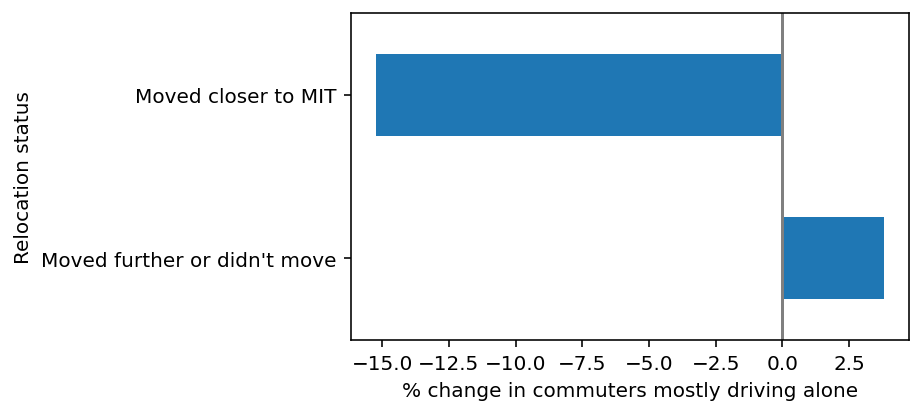

In [932]:
pt_distance_agg_change_df = pd.DataFrame({
        'N': [
            len(s_16_18_df[s_16_18_df[MOVED_CLOSER_PT]==True]),
            len(s_16_18_df[s_16_18_df[MOVED_CLOSER_PT]==False]),
        ],
        'Primarily drives alone (2016)': [
            s_16_18_df[s_16_18_df[MOVED_CLOSER_PT]==True][DRIVES_ALONE+' 2016'].sum(),
            s_16_18_df[s_16_18_df[MOVED_CLOSER_PT]==False][DRIVES_ALONE+' 2016'].sum(),
        ],
        'Primarily drives alone (2018)': [
            s_16_18_df[s_16_18_df[MOVED_CLOSER_PT]==True][DRIVES_ALONE+' 2018'].sum(),
            s_16_18_df[s_16_18_df[MOVED_CLOSER_PT]==False][DRIVES_ALONE+' 2018'].sum(),
        ]
    }, 
    index=pd.Index(
        data=['Moved closer to MIT', 'Moved further or didn\'t move'], 
        name='Relocation status'
    ))
pt_distance_agg_change_df.loc['Total'] = pt_distance_agg_change_df.sum()
pt_distance_agg_change_df['% Change in commuters mostly driving alone'] = \
    round(100*((pt_distance_agg_change_df['Primarily drives alone (2018)'] - pt_distance_agg_change_df['Primarily drives alone (2016)'])/pt_distance_agg_change_df['Primarily drives alone (2016)']), 2)

fig, ax = plt.subplots(figsize=(5,3))
pt_distance_agg_change_df.loc[
    ['Moved closer to MIT', 'Moved further or didn\'t move']
]['% Change in commuters mostly driving alone'].sort_values(ascending=False).plot.barh(ax=ax)
plt.axvline(0, color='gray')
plt.xlabel('% change in commuters mostly driving alone')

pt_distance_agg_change_df

In [933]:
# Restrict to people who lived within a feasible public transit commute distance both 2016 and 2018
pt_df = s_16_18_df[
    (s_16_18_df[PUBLIC_TRANSIT_TIME + ' 2016']<=90) & (s_16_18_df[PUBLIC_TRANSIT_TIME + ' 2018']<=90)
]
len(pt_df)

3651

N  Primarily drives alone (2016)  \
Relocation status                                                   
Moved closer to MIT            368                             38   
Moved further or didn't move  3283                            587   
Total                         3651                            625   

                              Primarily drives alone (2018)  \
Relocation status                                             
Moved closer to MIT                                      31   
Moved further or didn't move                            611   
Total                                                   642   

                              % Change in commuters mostly driving alone  
Relocation status                                                         
Moved closer to MIT                                               -18.42  
Moved further or didn't move                                        4.09  
Total                                                               2.72

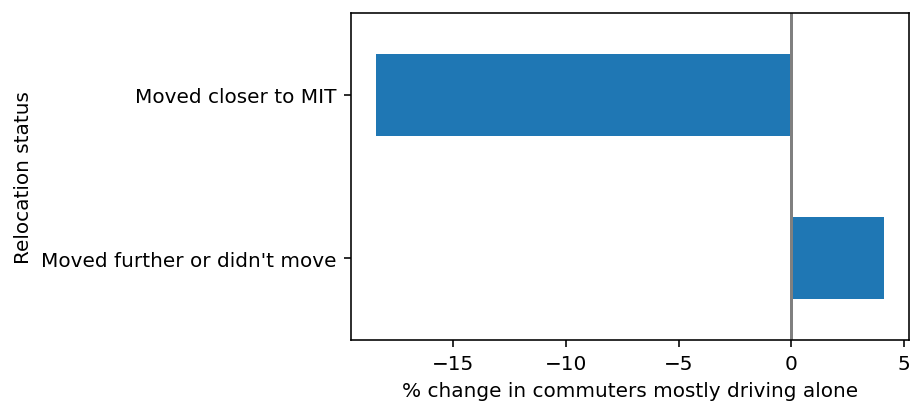

In [934]:
pt_distance_agg_change_df = pd.DataFrame({
        'N': [
            len(pt_df[pt_df[MOVED_CLOSER_PT]==True]),
            len(pt_df[pt_df[MOVED_CLOSER_PT]==False]),
        ],
        'Primarily drives alone (2016)': [
            pt_df[pt_df[MOVED_CLOSER_PT]==True][DRIVES_ALONE+' 2016'].sum(),
            pt_df[pt_df[MOVED_CLOSER_PT]==False][DRIVES_ALONE+' 2016'].sum(),
        ],
        'Primarily drives alone (2018)': [
            pt_df[pt_df[MOVED_CLOSER_PT]==True][DRIVES_ALONE+' 2018'].sum(),
            pt_df[pt_df[MOVED_CLOSER_PT]==False][DRIVES_ALONE+' 2018'].sum(),
        ]
    }, 
    index=pd.Index(
        data=['Moved closer to MIT', 'Moved further or didn\'t move'], 
        name='Relocation status'
    ))
pt_distance_agg_change_df.loc['Total'] = pt_distance_agg_change_df.sum()
pt_distance_agg_change_df['% Change in commuters mostly driving alone'] = \
    round(100*((pt_distance_agg_change_df['Primarily drives alone (2018)'] - pt_distance_agg_change_df['Primarily drives alone (2016)'])/pt_distance_agg_change_df['Primarily drives alone (2016)']), 2)

fig, ax = plt.subplots(figsize=(5,3))
pt_distance_agg_change_df.loc[
    ['Moved closer to MIT', 'Moved further or didn\'t move']
]['% Change in commuters mostly driving alone'].sort_values(ascending=False).plot.barh(ax=ax)
plt.axvline(0, color='gray')
plt.xlabel('% change in commuters mostly driving alone')

pt_distance_agg_change_df

N  Primarily drives alone (2016)  \
Relocation status                                                   
Moved closer to MIT            490                             48   
Moved further or didn't move  3161                            577   
Total                         3651                            625   

                              Primarily drives alone (2018)  \
Relocation status                                             
Moved closer to MIT                                      43   
Moved further or didn't move                            599   
Total                                                   642   

                              % Change in commuters mostly driving alone  
Relocation status                                                         
Moved closer to MIT                                               -10.42  
Moved further or didn't move                                        3.81  
Total                                                               2.72

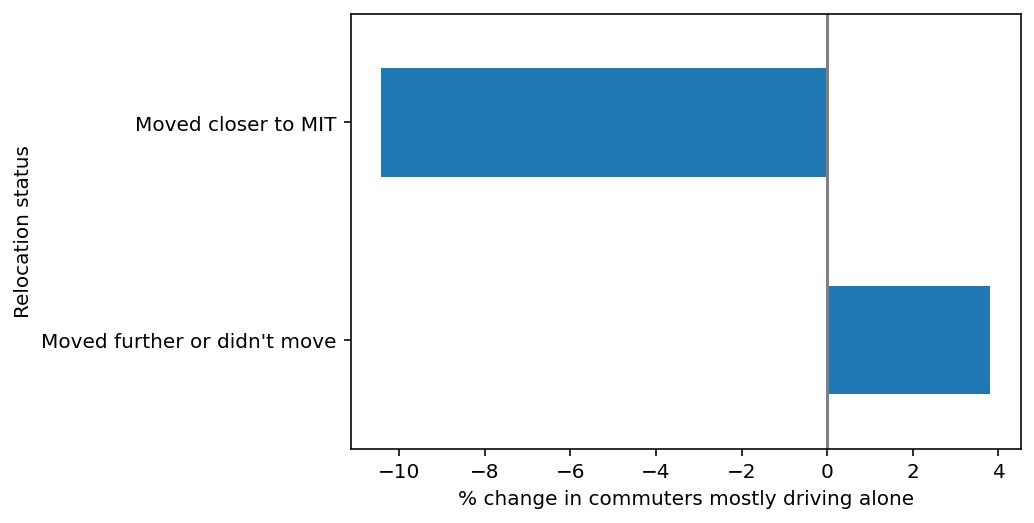

In [935]:
pt_v_driving_distance_agg_change_df = pd.DataFrame({
        'N': [
            len(pt_df[pt_df[MOVED_CLOSER_PT_VS_DRIVING_INDEX]==True]),
            len(pt_df[pt_df[MOVED_CLOSER_PT_VS_DRIVING_INDEX]==False]),
        ],
        'Primarily drives alone (2016)': [
            pt_df[pt_df[MOVED_CLOSER_PT_VS_DRIVING_INDEX]==True][DRIVES_ALONE+' 2016'].sum(),
            pt_df[pt_df[MOVED_CLOSER_PT_VS_DRIVING_INDEX]==False][DRIVES_ALONE+' 2016'].sum(),
        ],
        'Primarily drives alone (2018)': [
            pt_df[pt_df[MOVED_CLOSER_PT_VS_DRIVING_INDEX]==True][DRIVES_ALONE+' 2018'].sum(),
            pt_df[pt_df[MOVED_CLOSER_PT_VS_DRIVING_INDEX]==False][DRIVES_ALONE+' 2018'].sum(),
        ], 
    },
    index=pd.Index(
        data=['Moved closer to MIT', 'Moved further or didn\'t move'], 
        name='Relocation status'
    ))
pt_v_driving_distance_agg_change_df.loc['Total'] = pt_v_driving_distance_agg_change_df.sum()
pt_v_driving_distance_agg_change_df['% Change in commuters mostly driving alone'] = \
    round(100*((pt_v_driving_distance_agg_change_df['Primarily drives alone (2018)'] \
                - pt_v_driving_distance_agg_change_df['Primarily drives alone (2016)'])\
               /pt_v_driving_distance_agg_change_df['Primarily drives alone (2016)']), 2)

pt_v_driving_distance_agg_change_df.loc[
    ['Moved closer to MIT', 'Moved further or didn\'t move']
]['% Change in commuters mostly driving alone'].sort_values(ascending=False).plot.barh()
plt.axvline(0, color='gray')
plt.xlabel('% change in commuters mostly driving alone')

pt_v_driving_distance_agg_change_df

# Test for statistical significance

## McNemar’s Test Statistic

Among the commuters who moved closer to  MIT between 2016 and 2018, is the decrease in the number of commuters who primarily drive alone statistically significant?

The McNemar’s Test Statistic is used.
https://en.wikipedia.org/wiki/McNemar%27s_test

In [936]:
from statsmodels.stats.contingency_tables import mcnemar

In [940]:
# Make the contingency table for the McNemar test
pt_moved_closer_df = pt_df[pt_df[MOVED_CLOSER_PT]==True]
pt_mcnemar_contingency_tbl = pd.DataFrame({
        'Primarily drives alone (2016)': [
            ((pt_moved_closer_df[DRIVES_ALONE+' 2016']==True) \
             & (pt_moved_closer_df[DRIVES_ALONE+' 2018']==True)
            ).sum(),
            ((pt_moved_closer_df[DRIVES_ALONE+' 2016']==True) \
             & (pt_moved_closer_df[DRIVES_ALONE+' 2018']==False)
            ).sum(),
        ],
        'Does not primarily drives alone (2016)': [
            ((pt_moved_closer_df[DRIVES_ALONE+' 2016']==False) \
             & (pt_moved_closer_df[DRIVES_ALONE+' 2018']==True)
            ).sum(),
            ((pt_moved_closer_df[DRIVES_ALONE+' 2016']==False) \
             & (pt_moved_closer_df[DRIVES_ALONE+' 2018']==False)
            ).sum(),
        ], 
    },
    index=pd.Index(
        data=['Primarily drives alone (2018)', 'Does not primarily drives alone (2018)']
    ))
pt_mcnemar_contingency_tbl.head()

Primarily drives alone (2016)  \
Primarily drives alone (2018)                                      23   
Does not primarily drives alone (2018)                             15   

                                        Does not primarily drives alone (2016)  
Primarily drives alone (2018)                                                8  
Does not primarily drives alone (2018)                                     322

In [942]:
# Since there is a cell with a value <25, exact must be used
data = [[23, 8],
         [15, 322]]
print(mcnemar(data, exact=True))

pvalue      0.21003961563110343
statistic   8.0


In [689]:
# Make the contingency table for the McNemar test
moved_closer_df = s_16_18_df[s_16_18_df[MOVED_CLOSER]==True]
mcnemar_contingency_tbl = pd.DataFrame({
        'Primarily drives alone (2016)': [
            ((moved_closer_df[DRIVES_ALONE+' 2016']==True) \
             & (moved_closer_df[DRIVES_ALONE+' 2018']==True)
            ).sum(),
            ((moved_closer_df[DRIVES_ALONE+' 2016']==True) \
             & (moved_closer_df[DRIVES_ALONE+' 2018']==False)
            ).sum(),
        ],
        'Does not primarily drives alone (2016)': [
            ((moved_closer_df[DRIVES_ALONE+' 2016']==False) \
             & (moved_closer_df[DRIVES_ALONE+' 2018']==True)
            ).sum(),
            ((moved_closer_df[DRIVES_ALONE+' 2016']==False) \
             & (moved_closer_df[DRIVES_ALONE+' 2018']==False)
            ).sum(),
        ], 
    },
    index=pd.Index(
        data=['Primarily drives alone (2018)', 'Does not primarily drives alone (2018)']
    ))
mcnemar_contingency_tbl.head()

Primarily drives alone (2016)  \
Primarily drives alone (2018)                                      30   
Does not primarily drives alone (2018)                             14   

                                        Does not primarily drives alone (2016)  
Primarily drives alone (2018)                                               11  
Does not primarily drives alone (2018)                                     319

In [686]:
# Since there is a cell with a value <25, exact must be used
data = [[30, 11],
         [14, 319]]
print(mcnemar(data, exact=True))

pvalue      0.690037965774536
statistic   11.0


We cannot reject the null hypothesis.

## Chi-Squared Test of Independence

This  test is used to test whether there is a statistically significant  association between two  variables:
- a. Relocation status: whether or not people moved closer to MIT
- b. Change in driving behavior: whether people increased, decreased, or did not change the number of days per week they commute to MIT by driving alone

Null hypothesis: these two variables are independent; there is no significant relationship between them. 

Alternative hypothesis: there is a statistically significant association between relocation status and change in driving behavior.



In [ ]:
from scipy.stats import chi2_contingency

In [598]:
contingency = pd.crosstab(
    s_16_18_df[MOVED_CLOSER].map({False: 'Moved further or didn’t move', True: 'Moved closer'}),
    s_16_18_df[DRIVES_ALONE_CHANGE].map({-1: 'Drives less', 0:'No change', 1: 'Drives more'})
)
contingency.index.rename('Relocation status', inplace=True)
contingency

change in driving alone from 2016 to 2018  Drives less  Drives more  No change
Relocation status                                                             
Moved closer                                        31           27        316
Moved further or didn’t move                       316          397       3003

In [599]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)

0.10439673616724462


In [604]:
contingency_pt = pd.crosstab(
    s_16_18_df[MOVED_CLOSER_PT].map({False: 'Moved further or didn’t move', True: MOVED_CLOSER_PT}),
    s_16_18_df[DRIVES_ALONE_CHANGE].map({-1: 'Drives less', 0:'No change', 1: 'Drives more'}),
)
contingency_pt.index.rename('Relocation status', inplace=True)
contingency_pt

change in driving alone from 2016 to 2018           Drives less  Drives more  \
Relocation status                                                              
Moved further or didn’t move                                312          394   
moved closer (in terms of commute via public tr...           35           30   

change in driving alone from 2016 to 2018           No change  
Relocation status                                              
Moved further or didn’t move                             2996  
moved closer (in terms of commute via public tr...        323

In [605]:
c, p, dof, expected = chi2_contingency(contingency_pt) 
# Print the p-value
print(p)

0.19705178576204085


We cannot reject the null hypothesis.